In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
# Numpy
import os
from tqdm import tqdm
import datetime
import zipfile
import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

# Visualization
from matplotlib import pyplot as plt
#%matplotlib inline
import seaborn as sns

# Scikit Learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Tensorflow 2.0
import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")
%load_ext tensorboard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Conv2DTranspose, Reshape, concatenate, RepeatVector
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
print(f"Imported Tensorflow")

# Scikit Learn image processing
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
print(f"Imported Scikit Learn Image Processing tools")

Tensorflow Version: 2.4.0
Imported Tensorflow
Imported Scikit Learn Image Processing tools


## Utilities

In [ ]:
def load_pretrained_vgg19_embedding(pretrained_weights):
    
    # Construct VGG19 model without the classifer and weights trained on imagenet data
    # '''Takes (224, 224, 3) RGB and returns the embeddings(predicions) generated on the RGB image'''
    feature_extractor = VGG19(input_shape=(224, 224, 3),
                              include_top = False)
    
    x = feature_extractor.output
    flat = Flatten()(x)
    fc_1 = Dense(1024, activation='relu')(flat)
    do_1 = Dropout(0.2)(fc_1)
    fc_2 = Dense(512, activation='relu')(do_1)
    do_2 = Dropout(0.3)(fc_2)
    output = Dense(9, activation= 'softmax')(do_2)

    embed_model = Model(feature_extractor.inputs, output)
    # Compile model
    embed_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(lr=0.0004),
                        metrics=["accuracy"])
    
    print("Model Compiled")
    
    embed_model.load_weights(pretrained_weights)
    print("Loaded Finetuned Weights")
    
    return embed_model

def block(x, n_convs, filters, strides, activation, block_name):
    '''
    This functions defines a convlution layer(s) in the encoder network.
    Couples a BatchNormalization layer after a convolution layer
    '''
    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), 
                                   strides = strides,activation=activation, 
                                   padding='same', name=f"{block_name}_conv{i+1}")(x)
        
        x = tf.keras.layers.BatchNormalization(name=f"{block_name}_batch_normalization{i+1}")(x)
    return x

def Colorization_Model():
    
    embed_input = Input(shape=(9,), name="pretrained_model_output") # Softmax from the classifier
    visible = Input(shape=(224,224,1), name="input_image")          # Input image - L channel from 
                                                                    # Lab color space
    
    # Encoder - Low Level Features Network  
    x = block(visible, 1, 64, (2,2), 'relu', 'LL1')
    x = block(x, 1, 128, (1,1), 'relu', 'LL2')
    x = block(x, 1, 128, (2,2), 'relu', 'LL3')
    x = block(x, 1, 256, (1,1), 'relu', 'LL4')
    x = block(x, 1, 256, (2,2), 'relu', 'LL5')
    x = block(x, 1, 512, (1,1), 'relu', 'LL6')
    
    ## Mid-Level Features Network
    # The shape of mid-level network output is a (256, 28, 28) or 784 pixels for each filter
    # This layer shape determines the number of copies of embedding vectors to generate
    
    x = block(x, 1, 512, (1,1), 'relu', 'ML1')
    x = block(x, 1, 256, (1,1), 'relu', 'ML2')
    
    ## Bridge Network
    # bridge connecting the mid level features with the VGG19 classification output
    # Helps the encoder-decoder model to learn features of each class for better colorization
    
    fusion_output = RepeatVector(28*28)(embed_input) # generates 784 copies of the classifier embedding (9,)
    fusion_output = Reshape(([28, 28, 9]))(fusion_output) # Reshape 784 to (28,28,9)
    fusion_output = tf.keras.layers.concatenate([x, fusion_output], axis=-1) # Attach this (28,28,9) to (28,28,256)
    fusion_output = block(fusion_output, 1, 256, (1,1), 'relu', 'FuL')
    
    ## Decoder Network
    decoder_output = block(fusion_output, 1, 128, (1,1), 'relu', 'DL1')
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = block(decoder_output, 1, 64, (1,1), 'relu', 'DL2')
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = block(decoder_output, 1, 32, (1,1), 'relu', 'DL3')
    decoder_output = block(decoder_output, 1, 16, (1,1), 'relu', 'DL4')
    decoder_output = block(decoder_output, 1,  2, (1,1), 'tanh', 'DL5')
    decoder_output = UpSampling2D((2, 2), name='colorization')(decoder_output)
    
    # Define inputs, outputs and compile the model  
    model = Model(inputs = [visible, embed_input], outputs = [decoder_output])
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=optimizer, 
                loss = 'mse',
                metrics = tf.keras.metrics.RootMeanSquaredError())
    
    return model

def getImages(filelist, transform_size=(224, 224, 3)):
    """Reads image filelist from DATASET and returns float represtation of RGB [0.0, 1.0]"""
    img_list = []
    for filename in tqdm(filelist):
        # Loads JPEG image and converts it to numpy float array.
        image_in = img_to_array(load_img(filename))
        
        # [0.0, 255.0] => [0.0, 1.0]
        image_in = image_in/255
        
        if transform_size is not None:
            image_in = resize(image_in, transform_size, mode='reflect')

        img_list.append(image_in)
    img_list = np.array(img_list)
    
    return img_list

def preprocess_images(rgb, embed_model, input_size=(224,224,3), embed_size=(224,224,3)):
    # Resize for embed and convert to grayscale
    gray = gray2rgb(rgb2gray(rgb))
    gray = batch_apply(gray, resize, embed_size, mode='constant')
    # Zero-Center [-1,1]
    gray = gray * 2 - 1
    # generate embeddings
    embed = create_pretrained_embedding(embed_model, gray)

    # Resize to input size of model
    re_batch = batch_apply(rgb, resize, input_size, mode='constant')
    # RGB => L*a*b*
    re_batch = batch_apply(re_batch, rgb2lab)

    # Extract L* into X, zero-center and normalize
    X_batch = re_batch[:,:,:,0]
    X_batch = X_batch/50 - 1
    X_batch = X_batch.reshape(X_batch.shape+(1,))

    # Extract a*b* into Y and normalize. Already zero-centered.
    Y_batch = re_batch[:,:,:,1:]
    Y_batch = Y_batch/128

    return [X_batch, embed], Y_batch


def image_a_b_gen(images, batch_size, embed_model):
    for batch in datagen.flow(images, batch_size=batch_size):
        yield preprocess_images(batch, embed_model)
        

def train(model, embed_model, training_files, batch_size=20, epochs=500, steps_per_epoch=50):
    """Trains the model"""
    training_set = getImages(training_files)
    train_size = int(len(training_set)*0.85)
    train_images = training_set[:train_size]
    val_images = training_set[train_size:]
    val_steps = (len(val_images)//batch_size)
    print("Training samples:", train_size, "Validation samples:", len(val_images))
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=0, verbose=1, min_lr=1e-8),
        ModelCheckpoint(monitor='val_loss', filepath='model/colorize.hdf5', verbose=1,
                         save_best_only=True, save_weights_only=True, mode='auto'),
        
        

        TensorBoard(log_dir='/logs/fit/', histogram_freq=1, batch_size=20, write_graph=True, write_grads=True,
                    write_images=False, embeddings_freq=0),
        CSVLogger("/logs/training.log",separator=",", append=False)
    ]

    model.fit_generator(image_a_b_gen(train_images, batch_size, embed_model), epochs=epochs, steps_per_epoch=steps_per_epoch,
                        verbose=1, callbacks=callbacks, validation_data=preprocess_images(val_images, embed_model))

        
def batch_apply(ndarray, func, *args, **kwargs):
    """Calls func with samples, func should take ndarray as first positional argument"""

    batch = []
    for sample in ndarray:
        batch.append(func(sample, *args, **kwargs))
    return np.array(batch)

def create_pretrained_embedding(embed_model, rgb):
    """
    This function uses the pretrained CRC classifier and 
    returns the embedding thta predicts the tissue class 
    for a given RGB image
    """
    return embed_model.predict(rgb)

def plot_performance(hist, model_name):
    """
    Plots the accuracy and loss during the training process.
    Args: 
    history: variable assigned to model.fit()
    model_name: A string identifying the model
    """
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    fig.suptitle("{} Training".format(model_name), fontsize=20)

    max_epoch = len(hist.history['accuracy'])+1
    epochs_list = list(range(1, max_epoch))

    ax1.plot(epochs_list, hist.history['accuracy'], color='b', linestyle='-', label='Training Data')
    ax1.plot(epochs_list, hist.history['val_accuracy'], color='r', linestyle='-', label ='Validation Data')
    ax1.set_title('Accuracy', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.legend(frameon=False, loc='lower center', ncol=2)

    ax2.plot(epochs_list, hist.history['loss'], color='b', linestyle='-', label='Training Data')
    ax2.plot(epochs_list, hist.history['val_loss'], color='r', linestyle='-', label ='Validation Data')
    ax2.set_title('Loss', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.legend(frameon=False, loc='upper center', ncol=2)
    
    if figure_directory:
        plt.savefig(figures+"/history")
    plt.show()

In [ ]:
pretrained_weights = '/content/drive/MyDrive/neural_colorization_workspace/vgg19_model_finetuned.h5'

In [ ]:
my_model = Colorization_Model()

In [ ]:
train_dir = '/floyd/input/crc/NCT-CRC-HE-100K'
os.listdir(train_dir)

['DEB', 'LYM', 'STR', '.DS_Store', 'TUM', 'MUC', 'ADI', 'NORM', 'MUS', 'BACK']

In [ ]:
DATASET = []
for folder in os.listdir(train_dir):
    if folder != ".DS_Store":
        subfolder = os.path.join(train_dir,folder)
        for fname in os.listdir(subfolder):
            #print(fname)
            DATASET.append(os.path.join(subfolder, fname))

In [ ]:
print(f"{len(DATASET)} images in the dataset")

100000 images in the dataset


In [ ]:
dataset = shuffle(DATASET)

In [ ]:
training_files, testing_files = train_test_split(dataset[:45000], test_size=0.15)

In [ ]:
len(training_files)

38250

In [ ]:
datagen = ImageDataGenerator(shear_range=0.2,
                             zoom_range=0.2,
                             rotation_range=20,
                             horizontal_flip=True)

In [ ]:
embed_model = load_pretrained_vgg19_embedding(pretrained_weights)

80142336/80134624 [==============================] - 1s 0us/step
Model Compiled
Loaded Finetuned Weights


In [ ]:
batch_size=50

In [ ]:
history = train(model = my_model, embed_model = embed_model, training_files = training_files, epochs=100)

100%|██████████| 38250/38250 [09:02<00:00, 70.45it/s] 


Training samples: 32512 Validation samples: 5738
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.8691 - root_mean_squared_error: 0.9322
Epoch 00001: val_loss improved from inf to 0.87870, saving model to model/colorize.hdf5
50/50 [==============================] - 92s 2s/step - loss: 0.8691 - root_mean_squared_error: 0.9322 - val_loss: 0.8787 - val_root_mean_squared_error: 0.9374 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.7571 - root_mean_squared_error: 0.8701
Epoch 00002: val_loss improved from 0.87870 to 0.83122, saving model to model/colorize.hdf5
50/50 [==============================] - 88s 2s/step - loss: 0.7571 - root_mean_squared_error: 0.8701 - val_loss: 0.8312 - val_root_mean_squared_error: 0.9117 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.6656 - root_mean_squared_error: 0.8159
Epoch 00003: val_loss

In [ ]:
print(f"{len(testing_files)} images in the test dataset")

6750 images in the test dataset


In [ ]:
testing_files[0].split(".")[0].split("/")[-1]

'BACK-KSHGFDRG'

In [ ]:
def test(model, embed_model, testing_files, save_actual=False, save_gray=False):
    print("Started")
    test_images = getImages(testing_files)
    
    model.load_weights(filepath='model/colorize.hdf5')

    print('Preprocessing Images')
    X_test, Y_test = preprocess_images(test_images, embed_model)
    
    print('Predicting')
    # Test model
    output = model.predict(X_test)
    
    # Rescale a*b* back. [-1.0, 1.0] => [-128.0, 128.0]
    output = output * 128
    Y_test = Y_test * 128

    # Output colorizations
    for i in range(len(output)):
        name = testing_files[i].split(".")[0].split("/")[-1]
        print('Saving '+str(i)+"th image " + name + ".png")
        
        lightness = X_test[0][i][:,:,0]
        
        #Rescale L* back. [-1.0, 1.0] => [0.0, 100.0]
        lightness = (lightness + 1) * 50
        
        predicted = np.zeros((224, 224, 3))
        predicted[:,:,0] = lightness
        predicted[:,:,1:] = output[i]
        plt.imsave("results/predicted/" + name + ".jpeg", lab2rgb(predicted))
        
        if save_gray:
            bnw = np.zeros((224, 224, 3))
            bnw[:,:,0] = lightness
            plt.imsave("results/bnw/" + name + ".jpeg", lab2rgb(bnw))
        
        if save_actual:
            actual = np.zeros((224, 224, 3))
            actual[:,:,0] = lightness
            actual[:,:,1:] = Y_test[i]
            plt.imsave("results/actual/" + name + ".jpeg", lab2rgb(actual))

In [ ]:
test(my_model, embed_model, testing_files, True, True)

  0%|          | 9/6750 [00:00<01:22, 81.99it/s]

Started


100%|██████████| 6750/6750 [01:31<00:00, 73.66it/s] 


Preprocessing Images
Predicting
Saving 0th image BACK-HCWTSWTC.png
Saving 1th image DEB-IAWDVIEE.png
Saving 2th image MUC-TGRMLTAN.png
Saving 3th image LYM-GGVLGWGA.png
Saving 4th image LYM-WSFPHFNG.png
Saving 5th image DEB-QADKTHCP.png
Saving 6th image DEB-RQKPVHGR.png
Saving 7th image MUS-LDANERGC.png
Saving 8th image TUM-HPYHPRCH.png
Saving 9th image MUS-HEYAHTAT.png
Saving 10th image DEB-TSIWYVLK.png
Saving 11th image NORM-CEASYSDM.png
Saving 12th image NORM-VPHQEQWL.png
Saving 13th image MUC-YWQARCGM.png
Saving 14th image NORM-PFGSADMN.png
Saving 15th image NORM-ICKLWLKV.png
Saving 16th image BACK-IFCGQIDM.png
Saving 17th image DEB-MNIQHQFI.png
Saving 18th image STR-RHHICKTV.png
Saving 19th image MUS-CYCNEAMH.png
Saving 20th image BACK-LVFNMGRS.png
Saving 21th image LYM-ELVSNWPF.png
Saving 22th image TUM-FVQSQHHL.png
Saving 23th image BACK-AGTAVTHQ.png
Saving 24th image STR-KDSYSLAC.png
Saving 25th image NORM-IRICKRPI.png
Saving 26th image DEB-YMLLWYSL.png
Saving 27th image MUC-LH

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 61 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 72th image MUS-GYGLQWFG.png
Saving 73th image ADI-NGYRQVLM.png
Saving 74th image LYM-TTFGSKQS.png
Saving 75th image TUM-HYENCPRF.png
Saving 76th image MUC-DYVRPIRT.png
Saving 77th image DEB-NTKQPMLW.png
Saving 78th image TUM-VPMYVFMS.png
Saving 79th image STR-EAYENWGI.png
Saving 80th image ADI-ICPGGDDG.png
Saving 81th image NORM-SEHTRNDN.png
Saving 82th image ADI-SGCCNTRH.png
Saving 83th image ADI-NVSHLQAT.png
Saving 84th image MUS-MHCKHPFN.png
Saving 85th image BACK-GANGQLTK.png
Saving 86th image BACK-MKVMQHVY.png
Saving 87th image ADI-FMCNLGQF.png
Saving 88th image TUM-HSTPQPYT.png
Saving 89th image NORM-RDVKPSMR.png
Saving 90th image MUC-GANTQIVQ.png
Saving 91th image BACK-MSVKMHVQ.png
Saving 92th image MUC-KTWKQPWY.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 2314 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 93th image LYM-KSHMMDSQ.png
Saving 94th image NORM-CKPEDIPE.png
Saving 95th image MUC-HCDKTVHM.png
Saving 96th image MUC-SESCVGSK.png
Saving 97th image MUS-INQPTAFE.png
Saving 98th image MUS-APAGTSDF.png
Saving 99th image NORM-QCVLHDRV.png
Saving 100th image TUM-VSNTKRLV.png
Saving 101th image ADI-MWPFSHNT.png
Saving 102th image MUS-PPVKHMKQ.png
Saving 103th image DEB-MEGNATCM.png
Saving 104th image NORM-CKTPVSWQ.png
Saving 105th image DEB-GHMAERSP.png
Saving 106th image BACK-EVPQPSYL.png
Saving 107th image MUC-CTIKFHGT.png
Saving 108th image STR-EHGFQPLS.png
Saving 109th image ADI-PLQHDCST.png
Saving 110th image BACK-IHQGHSIN.png
Saving 111th image NORM-FTIDWYLF.png
Saving 112th image TUM-AVYSDLHD.png
Saving 113th image DEB-CDARICNF.png
Saving 114th image STR-DETLFVVF.png
Saving 115th image BACK-NYVNTRIK.png
Saving 116th image MUC-QSVRHRFR.png
Saving 117th image ADI-LSNADMHD.png
Saving 118th image ADI-QANFVGVN.png
Saving 119th image ADI-IFDWPRTL.png
Saving 120th image MUS-MGWNE

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 321th image DEB-IQPKMAVA.png
Saving 322th image DEB-HQSWKRAT.png
Saving 323th image DEB-TLQKSNRQ.png
Saving 324th image STR-HKLRKSSK.png
Saving 325th image ADI-EAKECWPG.png
Saving 326th image STR-QFPCEKMW.png
Saving 327th image DEB-WENFNRAH.png
Saving 328th image NORM-NRNRFFKS.png
Saving 329th image BACK-ELHRGNDN.png
Saving 330th image NORM-VLNFVTTI.png
Saving 331th image TUM-IHCIGNKF.png
Saving 332th image LYM-LSDQVPLR.png
Saving 333th image TUM-YDTIDTFL.png
Saving 334th image STR-LPTRHRWP.png
Saving 335th image TUM-EGYIDYRD.png
Saving 336th image STR-YWMHDNVV.png
Saving 337th image MUC-MGDNGMLG.png
Saving 338th image BACK-CGCGQVEH.png
Saving 339th image STR-WSKVELQS.png
Saving 340th image MUC-SNTMILAC.png
Saving 341th image NORM-WAKTYCYR.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 71 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 342th image TUM-EERCLEII.png
Saving 343th image DEB-TFMMSRVL.png
Saving 344th image DEB-QKYCFLTD.png
Saving 345th image MUS-NKRGGPHT.png
Saving 346th image TUM-EFYWTTRN.png
Saving 347th image TUM-KWPGWPIF.png
Saving 348th image ADI-KTRGGNNE.png
Saving 349th image ADI-DRFHMLNH.png
Saving 350th image BACK-FDFTPSDI.png
Saving 351th image MUC-RPCLHEVS.png
Saving 352th image TUM-SGWLYHWY.png
Saving 353th image MUS-EWASLVRF.png
Saving 354th image ADI-QMRRHVHD.png
Saving 355th image BACK-LCHKRSVW.png
Saving 356th image TUM-FLHTDMHE.png
Saving 357th image DEB-NRMTSWNK.png
Saving 358th image BACK-KQLIQVVN.png
Saving 359th image TUM-PEVDEDHN.png
Saving 360th image BACK-LHDGVNYE.png
Saving 361th image MUS-GMWNWSCS.png
Saving 362th image LYM-PIIIWNMC.png
Saving 363th image LYM-RDWDHFLE.png
Saving 364th image TUM-NNMNNKTF.png
Saving 365th image MUS-ILIYDYAL.png
Saving 366th image ADI-FFQLPWTL.png
Saving 367th image TUM-FIAHWWMP.png
Saving 368th image DEB-QLWTTNVC.png
Saving 369th image TUM-Y

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 438th image BACK-ARQNCFCG.png
Saving 439th image ADI-AAGQKKEG.png
Saving 440th image BACK-NDICNGGN.png
Saving 441th image MUS-SETIKLTA.png
Saving 442th image MUS-PYDEEKVE.png
Saving 443th image MUC-QHGVLIPY.png
Saving 444th image MUS-QAYFGEEV.png
Saving 445th image LYM-HGPYDCYP.png
Saving 446th image ADI-NHPFARKQ.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 447th image DEB-SPLFQDHF.png
Saving 448th image STR-FMNYNYQV.png
Saving 449th image ADI-DVWIHNYA.png
Saving 450th image DEB-NKVSVGLI.png
Saving 451th image DEB-FLRHCGCY.png
Saving 452th image MUS-HKCQYTTI.png
Saving 453th image MUS-MHFAVACC.png
Saving 454th image ADI-MCSLFDQH.png
Saving 455th image BACK-IAGEMFQN.png
Saving 456th image MUS-DLEDLNEY.png
Saving 457th image DEB-PDCYHGAA.png
Saving 458th image TUM-LINSSSNS.png
Saving 459th image ADI-AINCAYEW.png
Saving 460th image NORM-WFVLCHYH.png
Saving 461th image MUS-TYNWDFAG.png
Saving 462th image LYM-WGVMSNYY.png
Saving 463th image MUS-DCFQSICP.png
Saving 464th image STR-YLNLTWGK.png
Saving 465th image LYM-HIYFRPGP.png
Saving 466th image MUC-HIGYDLFC.png
Saving 467th image MUC-WGISIAWG.png
Saving 468th image MUS-TWYDNLWQ.png
Saving 469th image LYM-EHVSCQIP.png
Saving 470th image LYM-LNNQDKIT.png
Saving 471th image STR-ILWNVPIV.png
Saving 472th image STR-YQDEAKKV.png
Saving 473th image TUM-IFKEKGWR.png
Saving 474th image BACK-KV

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 288 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 646th image TUM-KWQAWISK.png
Saving 647th image MUS-ICNEYCTR.png
Saving 648th image MUS-CQGAIQPD.png
Saving 649th image ADI-AKAKEKAC.png
Saving 650th image DEB-CHRVWYFA.png
Saving 651th image MUS-QSVSLFFV.png
Saving 652th image BACK-HPGCGMPC.png
Saving 653th image MUC-EWSHYTWA.png
Saving 654th image ADI-FLAFWLLN.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1882 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 655th image LYM-WKYVRVGG.png
Saving 656th image DEB-VAFFRIKY.png
Saving 657th image MUS-GNKTPCHV.png
Saving 658th image TUM-WTFVRWWF.png
Saving 659th image NORM-MSEVDDFI.png
Saving 660th image ADI-HHPKYEFI.png
Saving 661th image LYM-SVFPAGRC.png
Saving 662th image MUC-HTHPWHHH.png
Saving 663th image NORM-KNNTNKPK.png
Saving 664th image ADI-RNSDDDKL.png
Saving 665th image MUS-PQWDPWPY.png
Saving 666th image LYM-CWCRSRMS.png
Saving 667th image TUM-MYGHQKER.png
Saving 668th image BACK-IWDNSCQS.png
Saving 669th image MUC-IHTLEEET.png
Saving 670th image MUS-IRHSGTPM.png
Saving 671th image DEB-IESIGFGM.png
Saving 672th image STR-NKWDYYAW.png
Saving 673th image STR-TRPEVFKI.png
Saving 674th image MUS-GMTPRKID.png
Saving 675th image NORM-RDCTMNIV.png
Saving 676th image MUS-CAVRAQAL.png
Saving 677th image STR-HMIEATTM.png
Saving 678th image TUM-KSCGSVKC.png
Saving 679th image MUC-QGKVVPIA.png
Saving 680th image LYM-QLDEPFEE.png
Saving 681th image LYM-HHGVIRFY.png
Saving 682th image DEB-A

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 721th image ADI-SCFETWRR.png
Saving 722th image DEB-ASLMTWQE.png
Saving 723th image TUM-ATFFHSRV.png
Saving 724th image MUS-PIGLYAQW.png
Saving 725th image LYM-CCCVSVYR.png
Saving 726th image BACK-DWEIEPCA.png
Saving 727th image NORM-LNIDIPAE.png
Saving 728th image TUM-MFTCMVAQ.png
Saving 729th image DEB-TGLEYADQ.png
Saving 730th image ADI-RSLDKCDK.png
Saving 731th image ADI-RHEHYQKT.png
Saving 732th image STR-QVESVKCV.png
Saving 733th image NORM-PCLNRRVP.png
Saving 734th image BACK-PEWCMFHA.png
Saving 735th image DEB-LPSWFDEN.png
Saving 736th image MUS-QGESLEAE.png
Saving 737th image MUS-DIDCNMQW.png
Saving 738th image MUS-NMPMKVQI.png
Saving 739th image NORM-CSMQLNFM.png
Saving 740th image TUM-EHDAFIKI.png
Saving 741th image BACK-ENWGAIQH.png
Saving 742th image NORM-QPWTHHQE.png
Saving 743th image TUM-KPRWKHEP.png
Saving 744th image NORM-PCGHHCNW.png
Saving 745th image LYM-HAIPQSAA.png
Saving 746th image MUC-TPNELEEH.png
Saving 747th image MUC-HYLFMPNY.png
Saving 748th image B

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 29 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 751th image NORM-MVGNFCYC.png
Saving 752th image NORM-WNRPGAPV.png
Saving 753th image BACK-CKDDVYGS.png
Saving 754th image ADI-ESFQMICK.png
Saving 755th image DEB-DSKYQWAF.png
Saving 756th image TUM-LYGNSWTM.png
Saving 757th image DEB-RMITQNIL.png
Saving 758th image LYM-SPCYLLLQ.png
Saving 759th image LYM-SKETEIGM.png
Saving 760th image LYM-ELCVQPVD.png
Saving 761th image DEB-FDMPSIAK.png
Saving 762th image ADI-AYTGHVIA.png
Saving 763th image ADI-AWYAWMSI.png
Saving 764th image ADI-GCMMTYSV.png
Saving 765th image MUS-PPLAAAHP.png
Saving 766th image MUC-ITTNWAGE.png
Saving 767th image TUM-AIDTFAQT.png
Saving 768th image STR-YEQRSAKK.png
Saving 769th image ADI-FCASKFMP.png
Saving 770th image TUM-KYQLRTVD.png
Saving 771th image NORM-ARFWADWS.png
Saving 772th image TUM-RCANTFSK.png
Saving 773th image NORM-VHTYEDCE.png
Saving 774th image ADI-QVQHQSPS.png
Saving 775th image ADI-KMTYWDDA.png
Saving 776th image MUC-IYKEPRGM.png
Saving 777th image TUM-DIYKYTSA.png
Saving 778th image TUM-

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 2041 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 853th image STR-KQIMDRKQ.png
Saving 854th image LYM-FDKMSIPN.png
Saving 855th image MUS-HWVEDKIM.png
Saving 856th image NORM-YNWCQVMP.png
Saving 857th image LYM-VGIPDCDW.png
Saving 858th image BACK-ESEAESIT.png
Saving 859th image NORM-DVNKSDTG.png
Saving 860th image LYM-FQENDVIF.png
Saving 861th image NORM-CYIRVPYQ.png
Saving 862th image NORM-HCIKYTML.png
Saving 863th image TUM-WNAPSQHI.png
Saving 864th image DEB-FQRQAPCS.png
Saving 865th image DEB-KADHRWWR.png
Saving 866th image DEB-CAIWSRDL.png
Saving 867th image MUC-RHAAKLMP.png
Saving 868th image MUS-DQEHAMQC.png
Saving 869th image NORM-HMCLGVSW.png
Saving 870th image MUC-CEQACKYK.png
Saving 871th image TUM-NTESMCPE.png
Saving 872th image BACK-FDIGVHYD.png
Saving 873th image STR-FYNIDIDK.png
Saving 874th image LYM-YICNNLQD.png
Saving 875th image TUM-EINCFNPM.png
Saving 876th image ADI-LFIQDWPR.png
Saving 877th image LYM-RIWVLHNY.png
Saving 878th image STR-STERFLTW.png
Saving 879th image NORM-CVKLAMSK.png
Saving 880th image T

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 966th image NORM-CMPFYDVE.png
Saving 967th image TUM-PPCCNTLE.png
Saving 968th image NORM-EACWFGAA.png
Saving 969th image LYM-KTGFWPIF.png
Saving 970th image DEB-ELHWSHMP.png
Saving 971th image NORM-NPSNSFNE.png
Saving 972th image LYM-IVHWNGCQ.png
Saving 973th image BACK-HIVSKNFP.png
Saving 974th image STR-EMLPNPTL.png
Saving 975th image MUS-RQHIEQPR.png
Saving 976th image STR-LRQWDLTH.png
Saving 977th image NORM-YMGPLKED.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 17 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 978th image DEB-VYCHAIYP.png
Saving 979th image STR-CQERLILH.png
Saving 980th image TUM-CSQMQHVE.png
Saving 981th image STR-RRNGKARK.png
Saving 982th image ADI-KTDWAFER.png
Saving 983th image MUS-IKNHGNSQ.png
Saving 984th image BACK-ARPCKWNK.png
Saving 985th image LYM-CPFIWSPM.png
Saving 986th image TUM-NKSMKLLF.png
Saving 987th image ADI-QIDSVMNE.png
Saving 988th image LYM-TYCFLEYI.png
Saving 989th image BACK-HTWDHRKK.png
Saving 990th image TUM-WEAQVFYH.png
Saving 991th image NORM-KNSKRNEH.png
Saving 992th image MUS-RAVSQCRD.png
Saving 993th image TUM-VKRAEMAS.png
Saving 994th image DEB-HDVWGSAK.png
Saving 995th image BACK-AYTWYKFS.png
Saving 996th image NORM-FWAAMGLT.png
Saving 997th image ADI-QNSVLWPV.png
Saving 998th image TUM-FHCASTPT.png
Saving 999th image LYM-KIVFKESN.png
Saving 1000th image DEB-FPYEEIKD.png
Saving 1001th image LYM-PNEGEVHK.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 115 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1002th image MUS-ELYSCGSF.png
Saving 1003th image DEB-TPVWFKEH.png
Saving 1004th image LYM-YLMTVDGF.png
Saving 1005th image TUM-PNQSRCDP.png
Saving 1006th image TUM-WKWKGSDP.png
Saving 1007th image DEB-CTVAWVQS.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 198 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1008th image DEB-AILDKTIW.png
Saving 1009th image TUM-ILRFWNAH.png
Saving 1010th image MUS-SWNPWLNP.png
Saving 1011th image BACK-FECLRLWY.png
Saving 1012th image ADI-DTEMWQGA.png
Saving 1013th image DEB-YDWRTLMF.png
Saving 1014th image DEB-GHAKYFVN.png
Saving 1015th image LYM-MWMDPFWY.png
Saving 1016th image LYM-DMEKRSSD.png
Saving 1017th image STR-DSHGCSET.png
Saving 1018th image DEB-PSCLLAPI.png
Saving 1019th image LYM-ELYKCQSL.png
Saving 1020th image NORM-DCTEKHQF.png
Saving 1021th image NORM-VYKPWFRL.png
Saving 1022th image NORM-ATQEEVKP.png
Saving 1023th image NORM-KFKEGLKR.png
Saving 1024th image STR-PDPCLIQG.png
Saving 1025th image MUS-MFDCMTFL.png
Saving 1026th image TUM-TDAVWYRT.png
Saving 1027th image STR-CMRNGPSL.png
Saving 1028th image ADI-AVKMQEIS.png
Saving 1029th image MUS-LLVMHKNQ.png
Saving 1030th image MUS-IGQQAWWW.png
Saving 1031th image ADI-GIQVSICK.png
Saving 1032th image STR-ESVVHHTC.png
Saving 1033th image STR-RHPIFWIK.png
Saving 1034th image STR-DTAYYFRG.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 993 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1044th image BACK-EEKWIWWY.png
Saving 1045th image NORM-APHRLVHG.png
Saving 1046th image MUS-PWIWKRYT.png
Saving 1047th image BACK-ELHLRVKD.png
Saving 1048th image DEB-IYQFTGER.png
Saving 1049th image ADI-KSAIQEVC.png
Saving 1050th image MUS-NGKRDFLG.png
Saving 1051th image MUS-KSPYYILP.png
Saving 1052th image DEB-DSQLMNGY.png
Saving 1053th image DEB-EIQIKYQV.png
Saving 1054th image BACK-GKMPPQWS.png
Saving 1055th image NORM-RVLMVRLW.png
Saving 1056th image ADI-IPTYASKE.png
Saving 1057th image STR-GKNYDDAI.png
Saving 1058th image TUM-PHHKPDAE.png
Saving 1059th image STR-NTEQRWDH.png
Saving 1060th image NORM-ENSADAWD.png
Saving 1061th image STR-YQYVHAWT.png
Saving 1062th image BACK-HTCRKLII.png
Saving 1063th image DEB-DPQRHNCN.png
Saving 1064th image MUC-WGCYRQWM.png
Saving 1065th image DEB-RNGDLMFD.png
Saving 1066th image NORM-IDVEMFAS.png
Saving 1067th image ADI-SISSQWVT.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 20 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1068th image LYM-STGQSAAW.png
Saving 1069th image DEB-YCERAVDM.png
Saving 1070th image BACK-KPQDQLQV.png
Saving 1071th image MUC-WRILLNYL.png
Saving 1072th image STR-AEFMVQRA.png
Saving 1073th image MUC-ITEQWWYI.png
Saving 1074th image ADI-QTHRNLQI.png
Saving 1075th image LYM-TSPAGSFC.png
Saving 1076th image LYM-HCMTFFDM.png
Saving 1077th image DEB-PREEARRS.png
Saving 1078th image MUS-DINMQSGE.png
Saving 1079th image MUS-ADPIAMHW.png
Saving 1080th image DEB-KAQCIPEN.png
Saving 1081th image TUM-HSFVTHEY.png
Saving 1082th image ADI-KHMGVPDT.png
Saving 1083th image STR-ARCGTFRY.png
Saving 1084th image STR-GIMNKDWL.png
Saving 1085th image LYM-TSGYEESP.png
Saving 1086th image MUC-WCMVEGML.png
Saving 1087th image LYM-ECLEEHMQ.png
Saving 1088th image MUC-PTNFIQGQ.png
Saving 1089th image DEB-NRAYINQG.png
Saving 1090th image MUS-LADLFNFK.png
Saving 1091th image ADI-GICKPIII.png
Saving 1092th image ADI-IVNFTGMA.png
Saving 1093th image ADI-GKQQHWFR.png
Saving 1094th image ADI-LTLSVYEL.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1197th image MUC-EMLCMTFP.png
Saving 1198th image TUM-RMPFLMRC.png
Saving 1199th image DEB-ASAAQYMI.png
Saving 1200th image BACK-IYPTYCKV.png
Saving 1201th image BACK-IEQHIGYK.png
Saving 1202th image MUC-AANGSTRR.png
Saving 1203th image DEB-CLPDKYFA.png
Saving 1204th image TUM-ACRVEYFK.png
Saving 1205th image LYM-DAFFDVCV.png
Saving 1206th image TUM-TNMNIGDR.png
Saving 1207th image ADI-PGAVFHTY.png
Saving 1208th image STR-WKANEAWK.png
Saving 1209th image BACK-NWLHCWVW.png
Saving 1210th image ADI-KDRLFRAN.png
Saving 1211th image MUS-CNLRDPEM.png
Saving 1212th image STR-MYSDRQVD.png
Saving 1213th image TUM-IQAKTHGD.png
Saving 1214th image STR-PCNWYYNC.png
Saving 1215th image ADI-LGIVMYIH.png
Saving 1216th image MUS-DEEVSQYF.png
Saving 1217th image STR-KKPHANVC.png
Saving 1218th image DEB-ALDSTAIT.png
Saving 1219th image TUM-ECEFSKLV.png
Saving 1220th image BACK-EPNMPAFL.png
Saving 1221th image STR-RHTWSPQS.png
Saving 1222th image ADI-RNHSKIAD.png
Saving 1223th image TUM-YCVFIPIA.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 23 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1298th image STR-HAMLMIQE.png
Saving 1299th image DEB-RRWGLWRR.png
Saving 1300th image MUC-FNINSSCA.png
Saving 1301th image BACK-FWYNGEIC.png
Saving 1302th image LYM-VLDKIHVK.png
Saving 1303th image LYM-EEEECLFD.png
Saving 1304th image NORM-DKNWGITA.png
Saving 1305th image MUC-NDPFNINV.png
Saving 1306th image BACK-HGEGQNEA.png
Saving 1307th image MUS-ACTYDCNK.png
Saving 1308th image ADI-LEVSNDCL.png
Saving 1309th image STR-TSVDMCWV.png
Saving 1310th image STR-KVTDFKKM.png
Saving 1311th image LYM-RAAHSQYF.png
Saving 1312th image TUM-TMVCCHPG.png
Saving 1313th image NORM-NYPLCDCL.png
Saving 1314th image MUS-DDRNHWDQ.png
Saving 1315th image STR-RFFFFSEV.png
Saving 1316th image DEB-RKKAIIHY.png
Saving 1317th image LYM-EIIGGSCM.png
Saving 1318th image TUM-NRYQSPPM.png
Saving 1319th image MUS-PGTWQCCK.png
Saving 1320th image LYM-TYCMNCAT.png
Saving 1321th image STR-KKQMHEGW.png
Saving 1322th image TUM-GCFCKEWY.png
Saving 1323th image MUS-PRVECLEN.png
Saving 1324th image ADI-GYHADGRT.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1649 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1349th image TUM-DLTRARRN.png
Saving 1350th image TUM-CMPRSSAD.png
Saving 1351th image MUS-RVTVIESH.png
Saving 1352th image NORM-HDMPDFHE.png
Saving 1353th image NORM-MFFWGSRD.png
Saving 1354th image DEB-DHHHRGFF.png
Saving 1355th image STR-IHWDCSLL.png
Saving 1356th image NORM-GQIIFRKR.png
Saving 1357th image TUM-TALWRNIK.png
Saving 1358th image ADI-GSACFASF.png
Saving 1359th image NORM-EPWCKQQC.png
Saving 1360th image STR-VRHGLHYN.png
Saving 1361th image LYM-YLDDFCGW.png
Saving 1362th image TUM-SKFSPRNR.png
Saving 1363th image TUM-WYEDWWML.png
Saving 1364th image MUS-IIKNICYH.png
Saving 1365th image LYM-WDPTARSG.png
Saving 1366th image MUS-LLHQKSSQ.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 92 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1367th image ADI-NIQYDKVM.png
Saving 1368th image MUS-IYEAVDQA.png
Saving 1369th image DEB-TITILFTN.png
Saving 1370th image MUS-IHPKICME.png
Saving 1371th image LYM-VIDMLHQY.png
Saving 1372th image TUM-FPWTNKIV.png
Saving 1373th image MUS-KMVGPDIM.png
Saving 1374th image ADI-NENRFGQA.png
Saving 1375th image NORM-TGVCTCSE.png
Saving 1376th image BACK-NMDAEHFN.png
Saving 1377th image ADI-HCFGYHHN.png
Saving 1378th image MUS-EKGWNRHL.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 94 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1379th image LYM-GFHTSICD.png
Saving 1380th image DEB-IDNTEHDF.png
Saving 1381th image NORM-HRWGWNDF.png
Saving 1382th image TUM-HKNIIYNF.png
Saving 1383th image STR-EFCDSFHV.png
Saving 1384th image BACK-CMCYRNNP.png
Saving 1385th image ADI-GAQTILCY.png
Saving 1386th image STR-FDKYEWMG.png
Saving 1387th image TUM-DGHQNSLA.png
Saving 1388th image MUC-SMQPNYFV.png
Saving 1389th image LYM-KIYKDGLG.png
Saving 1390th image TUM-RATAVECA.png
Saving 1391th image DEB-GLFWCWWC.png
Saving 1392th image MUC-FDVVYLFF.png
Saving 1393th image BACK-LHIMCLYP.png
Saving 1394th image ADI-GDREVMCE.png
Saving 1395th image TUM-NNAPTHLY.png
Saving 1396th image LYM-WPYNNKAR.png
Saving 1397th image ADI-GVECYFHH.png
Saving 1398th image ADI-PGKGGPWF.png
Saving 1399th image BACK-GNRCKQAD.png
Saving 1400th image MUC-YRYWYDTK.png
Saving 1401th image BACK-GKQRTCLG.png
Saving 1402th image TUM-EISKLQTY.png
Saving 1403th image BACK-NTKNPMFI.png
Saving 1404th image STR-YSKDMMTP.png
Saving 1405th image MUC-RAPKEESQ

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 30 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1463th image ADI-ASRNHMDT.png
Saving 1464th image ADI-KRCICNDA.png
Saving 1465th image NORM-ECRNWDKC.png
Saving 1466th image NORM-FAWFWPTE.png
Saving 1467th image TUM-LTAFTCYD.png
Saving 1468th image TUM-GQDLRRHR.png
Saving 1469th image BACK-HATYWGRF.png
Saving 1470th image TUM-WASTYCHS.png
Saving 1471th image TUM-YHKFWFMS.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 3126 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1472th image LYM-FYQQHHCM.png
Saving 1473th image NORM-EFFSYDET.png
Saving 1474th image MUC-KWWQRQCL.png
Saving 1475th image DEB-AMHGLQFE.png
Saving 1476th image MUC-KVCGMRCP.png
Saving 1477th image ADI-GDHDDKVG.png
Saving 1478th image ADI-KIGISYLE.png
Saving 1479th image MUS-CRLKYVIQ.png
Saving 1480th image NORM-HEVEGLMN.png
Saving 1481th image TUM-LTFRVDKI.png
Saving 1482th image NORM-GYPQCWED.png
Saving 1483th image BACK-NNLYDWGA.png
Saving 1484th image MUS-HPLTMFGH.png
Saving 1485th image ADI-AITGHLTM.png
Saving 1486th image TUM-GFWKFFAR.png
Saving 1487th image MUS-HGEFAVHM.png
Saving 1488th image TUM-PNNADIIR.png
Saving 1489th image DEB-WPITNCLG.png
Saving 1490th image LYM-FHWGMMHK.png
Saving 1491th image ADI-ESDKWYMM.png
Saving 1492th image STR-FTRIMCLV.png
Saving 1493th image ADI-CSPHNPVE.png
Saving 1494th image TUM-DNPPRLDS.png
Saving 1495th image BACK-HDTLNCYV.png
Saving 1496th image DEB-CGQWKMYE.png
Saving 1497th image LYM-CWRSFCMT.png
Saving 1498th image DEB-RIFDYKWQ.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 27 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1508th image TUM-YGRLHGSG.png
Saving 1509th image MUS-LSFFRFLR.png
Saving 1510th image TUM-TCYQETDD.png
Saving 1511th image BACK-CEYCSYLF.png
Saving 1512th image LYM-MPINEGWE.png
Saving 1513th image MUS-ENCYASNK.png
Saving 1514th image MUC-ANPPMFRG.png
Saving 1515th image BACK-EPDHMATP.png
Saving 1516th image ADI-MISKSPVS.png
Saving 1517th image MUS-FHMRQRSS.png
Saving 1518th image TUM-YFGSMIKH.png
Saving 1519th image TUM-RCHGSDAK.png
Saving 1520th image DEB-DLIWINQE.png
Saving 1521th image DEB-METTDFDL.png
Saving 1522th image DEB-SCIAKPHL.png
Saving 1523th image LYM-RPFSIETD.png
Saving 1524th image DEB-SAAWQIND.png
Saving 1525th image LYM-FCGMQNSI.png
Saving 1526th image MUS-MENVSHKY.png
Saving 1527th image MUC-EMHDFEIW.png
Saving 1528th image LYM-EKISMTIY.png
Saving 1529th image ADI-PEFIWPGL.png
Saving 1530th image ADI-RQWATQIN.png
Saving 1531th image MUS-IAPQEWIG.png
Saving 1532th image MUS-SWGCVDFN.png
Saving 1533th image DEB-SFDDFRFG.png
Saving 1534th image TUM-ELRDVFQI.png

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 2076 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1631th image NORM-ALAYGGQQ.png
Saving 1632th image STR-YTHEDFIH.png
Saving 1633th image MUS-HRCNERMW.png
Saving 1634th image NORM-QDACSQHW.png
Saving 1635th image LYM-VTEVGSFY.png
Saving 1636th image BACK-IWSEAHNT.png
Saving 1637th image STR-WHVWACSE.png
Saving 1638th image ADI-AYWKGIMF.png
Saving 1639th image MUS-KYFVTDEI.png
Saving 1640th image ADI-GEHDDGIM.png
Saving 1641th image NORM-EEANHVWE.png
Saving 1642th image LYM-MWDYTEYD.png
Saving 1643th image MUC-LMNECSEL.png
Saving 1644th image MUS-QWTRAYSH.png
Saving 1645th image NORM-TADPQIKG.png
Saving 1646th image DEB-WLPHDTAK.png
Saving 1647th image DEB-NDIRVFLH.png
Saving 1648th image MUS-RYINWCCT.png
Saving 1649th image MUS-LFWKIGQF.png
Saving 1650th image STR-KQRWYPPW.png
Saving 1651th image MUS-EDARYSDC.png
Saving 1652th image MUC-NCLHGQNY.png
Saving 1653th image LYM-IKGYGWDS.png
Saving 1654th image MUS-QQLHIRRN.png
Saving 1655th image MUC-MWATNTTP.png
Saving 1656th image NORM-IMRHDKHW.png
Saving 1657th image ADI-MTGEFIPN

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 16 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1676th image STR-WALGYNWM.png
Saving 1677th image LYM-GHCMCDER.png
Saving 1678th image DEB-RRSCIFPQ.png
Saving 1679th image BACK-MYVLNQHS.png
Saving 1680th image TUM-MNAPKTQM.png
Saving 1681th image MUS-ADSWWNMQ.png
Saving 1682th image DEB-PGMQISGS.png
Saving 1683th image MUS-NWGQSVAD.png
Saving 1684th image LYM-REKNYEPI.png
Saving 1685th image ADI-PHDVFVCN.png
Saving 1686th image LYM-KHQFIHVN.png
Saving 1687th image LYM-EGPMKTKN.png
Saving 1688th image DEB-NSQVGTWI.png
Saving 1689th image MUC-IWAPVYWC.png
Saving 1690th image STR-CQFELWWM.png
Saving 1691th image BACK-DGKDAWLE.png
Saving 1692th image MUS-PDIGHNTY.png
Saving 1693th image ADI-RASFNPDN.png
Saving 1694th image BACK-HLEFLPRF.png
Saving 1695th image STR-KFVKERIM.png
Saving 1696th image ADI-MYRKYASY.png
Saving 1697th image MUS-HITCPYNR.png
Saving 1698th image DEB-THNAITSV.png
Saving 1699th image DEB-QWQHRLMF.png
Saving 1700th image NORM-YMWPIQWA.png
Saving 1701th image MUC-HRGWRRSW.png
Saving 1702th image LYM-NIEFWCQR.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1718th image TUM-MNWQQSFR.png
Saving 1719th image NORM-NHEVSAQW.png
Saving 1720th image TUM-ALQAKMTT.png
Saving 1721th image STR-QKTALGDD.png
Saving 1722th image BACK-EHVIWHRA.png
Saving 1723th image BACK-AWIIDAAL.png
Saving 1724th image DEB-KFGFEIAR.png
Saving 1725th image TUM-NEDGDVII.png
Saving 1726th image ADI-GGHSSIFY.png
Saving 1727th image NORM-EQYPRADT.png
Saving 1728th image ADI-MQINATTM.png
Saving 1729th image BACK-GTIISTPF.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 2110 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 56 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1730th image MUC-EYSGPKHY.png
Saving 1731th image TUM-TWKVYNHS.png
Saving 1732th image TUM-GNGDMKCN.png
Saving 1733th image DEB-NWMFSWYW.png
Saving 1734th image TUM-CLPWSARC.png
Saving 1735th image ADI-RMFPWVSK.png
Saving 1736th image LYM-GKRRAPWD.png
Saving 1737th image MUS-QDHCIHCK.png
Saving 1738th image BACK-IQCENWLF.png
Saving 1739th image BACK-HAGSISWY.png
Saving 1740th image DEB-YKNSSPFI.png
Saving 1741th image STR-EQGSKIKY.png
Saving 1742th image ADI-RFEVRTMV.png
Saving 1743th image ADI-MFVVSQVH.png
Saving 1744th image TUM-RKHQDLYY.png
Saving 1745th image BACK-CKYGAENF.png
Saving 1746th image STR-YWTIENYA.png
Saving 1747th image MUC-GPEATFGD.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 786 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1748th image LYM-YNWFEHQQ.png
Saving 1749th image TUM-EVMQFISA.png
Saving 1750th image BACK-NVDIPWDQ.png
Saving 1751th image TUM-NVHARVGQ.png
Saving 1752th image STR-NGHAIMPR.png
Saving 1753th image BACK-LKNGYYMH.png
Saving 1754th image MUC-DMIEAINA.png
Saving 1755th image ADI-NTCFLMPC.png
Saving 1756th image MUS-SNFWFGGN.png
Saving 1757th image NORM-EQRVDGCT.png
Saving 1758th image LYM-MLGWRSWE.png
Saving 1759th image MUS-EVQECFEV.png
Saving 1760th image BACK-HQFKTHTI.png
Saving 1761th image TUM-QMQMHQTH.png
Saving 1762th image LYM-WQDECQPM.png
Saving 1763th image MUC-FMQHSSGI.png
Saving 1764th image MUS-KEFPQNVN.png
Saving 1765th image NORM-NIHDERML.png
Saving 1766th image ADI-FRSPREAM.png
Saving 1767th image TUM-WKHVWGHM.png
Saving 1768th image BACK-HYRDTKIW.png
Saving 1769th image DEB-VDPPCCNW.png
Saving 1770th image BACK-AFDRALSV.png
Saving 1771th image BACK-DKKVFCRM.png
Saving 1772th image DEB-EVWIEMRM.png
Saving 1773th image STR-HFLQQHMI.png
Saving 1774th image NORM-TRCTL

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1784th image TUM-PAWDAQMD.png
Saving 1785th image NORM-RYGAINSS.png
Saving 1786th image NORM-KWIFGVRS.png
Saving 1787th image STR-AGKRHVPI.png
Saving 1788th image MUC-DSSGKHHH.png
Saving 1789th image MUS-SAWSFEWR.png
Saving 1790th image LYM-TSACFHVN.png
Saving 1791th image MUS-LICRYQTY.png
Saving 1792th image MUS-FVPCIHGF.png
Saving 1793th image LYM-TTNNGQRW.png
Saving 1794th image ADI-PPQAEEHD.png
Saving 1795th image NORM-WQKMTTIP.png
Saving 1796th image LYM-QAMDRHNS.png
Saving 1797th image NORM-FCPHVEGW.png
Saving 1798th image MUS-TTDIYRIG.png
Saving 1799th image LYM-HPFCPLNE.png
Saving 1800th image LYM-LYCQYTHR.png
Saving 1801th image DEB-THRKGYWI.png
Saving 1802th image MUS-QWFFYVRS.png
Saving 1803th image LYM-FKGIQAIG.png
Saving 1804th image DEB-TKYAKNRL.png
Saving 1805th image ADI-LEYTLNRF.png
Saving 1806th image MUS-RQNCIPTP.png
Saving 1807th image ADI-MGYNQQFR.png
Saving 1808th image TUM-IHHHSNDE.png
Saving 1809th image ADI-HFNYDQSI.png
Saving 1810th image TUM-DNQVGADH.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1440 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1884th image NORM-VFRWQYDF.png
Saving 1885th image DEB-LVVWDKLD.png
Saving 1886th image LYM-LVDESWLA.png
Saving 1887th image MUS-DPGYQKPK.png
Saving 1888th image ADI-CDYQDHYD.png
Saving 1889th image DEB-RIMMDWYE.png
Saving 1890th image STR-IIFLTIAH.png
Saving 1891th image LYM-RREDDGYV.png
Saving 1892th image LYM-PKEHTGVF.png
Saving 1893th image BACK-GYQWLAKN.png
Saving 1894th image BACK-KGLPEAST.png
Saving 1895th image ADI-KSPRKLIW.png
Saving 1896th image BACK-ECLRIVMM.png
Saving 1897th image STR-MQFIHTTF.png
Saving 1898th image MUC-YGNPKGTD.png
Saving 1899th image LYM-MRAVCEGR.png
Saving 1900th image NORM-RAQVFRFW.png
Saving 1901th image LYM-PQCGWMFV.png
Saving 1902th image ADI-HMIRMVIM.png
Saving 1903th image MUC-WFNNQVWY.png
Saving 1904th image ADI-FGMKANTD.png
Saving 1905th image LYM-MYQDCRIS.png
Saving 1906th image MUC-RNKTQTRF.png
Saving 1907th image LYM-AMMVLTMP.png
Saving 1908th image BACK-MICRCTVW.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 154 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1909th image TUM-CNAHEKMN.png
Saving 1910th image TUM-KVIQDPLS.png
Saving 1911th image TUM-FPMQPESL.png
Saving 1912th image MUC-LLSRISKE.png
Saving 1913th image MUS-FLRLKIPY.png
Saving 1914th image ADI-HLVWVCNF.png
Saving 1915th image TUM-RMFRGDSP.png
Saving 1916th image ADI-PEGKYQYP.png
Saving 1917th image DEB-VEDQRPFC.png
Saving 1918th image DEB-IDFILESW.png
Saving 1919th image STR-LSMNNYVL.png
Saving 1920th image BACK-KIEEAIYT.png
Saving 1921th image MUS-DSVFEIDC.png
Saving 1922th image NORM-IGKPWRDS.png
Saving 1923th image MUC-GHRDYCKC.png
Saving 1924th image NORM-YEEEYVTG.png
Saving 1925th image TUM-QQEIKSYQ.png
Saving 1926th image MUS-FPKCFKPY.png
Saving 1927th image MUS-RWFDVDLN.png
Saving 1928th image BACK-GQREWSYE.png
Saving 1929th image NORM-IFPQEHMG.png
Saving 1930th image NORM-DPLVWNSS.png
Saving 1931th image MUS-SCTDKKNM.png
Saving 1932th image ADI-PKMSCCQS.png
Saving 1933th image TUM-KLRVDGSV.png
Saving 1934th image ADI-NVPINSVW.png
Saving 1935th image TUM-QLTLKYCY

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 414 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1945th image ADI-DAHESNVC.png
Saving 1946th image LYM-LSYHGQCN.png
Saving 1947th image MUS-QDESHWCY.png
Saving 1948th image BACK-ADHIRTER.png
Saving 1949th image NORM-NQMIMLFP.png
Saving 1950th image LYM-WALGLTDS.png
Saving 1951th image ADI-MRRDPPIW.png
Saving 1952th image TUM-HSPFMLYF.png
Saving 1953th image DEB-FAWHRCSA.png
Saving 1954th image STR-PLNAEDHI.png
Saving 1955th image STR-MECPHGAI.png
Saving 1956th image NORM-TMRNMWQM.png
Saving 1957th image TUM-DCEYFQIS.png
Saving 1958th image TUM-TRAWQRIL.png
Saving 1959th image TUM-QSWFYQAD.png
Saving 1960th image TUM-CELYVAGA.png
Saving 1961th image BACK-EQFQKSGW.png
Saving 1962th image BACK-MIQWFRMT.png
Saving 1963th image STR-RANALEKW.png
Saving 1964th image ADI-AIPSIYPN.png
Saving 1965th image MUS-CWPMRLEN.png
Saving 1966th image TUM-IWCWLMID.png
Saving 1967th image DEB-SYTRRFAH.png
Saving 1968th image MUS-PQWTPWRD.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 243 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 1969th image MUS-KHHARWVS.png
Saving 1970th image MUS-KLLREERT.png
Saving 1971th image ADI-RHWMKSFG.png
Saving 1972th image ADI-FQKFHALD.png
Saving 1973th image TUM-PHLLQYPQ.png
Saving 1974th image BACK-DVWDHCMM.png
Saving 1975th image STR-GPSMNFED.png
Saving 1976th image TUM-KRSEKHGA.png
Saving 1977th image MUC-NGHKHCWH.png
Saving 1978th image DEB-FNGIRMGL.png
Saving 1979th image MUC-WFLAKSLS.png
Saving 1980th image ADI-LDWPKGLQ.png
Saving 1981th image NORM-FINWYPYW.png
Saving 1982th image TUM-IPCKRGFD.png
Saving 1983th image MUC-VRVTDDFC.png
Saving 1984th image LYM-CVKTMLTI.png
Saving 1985th image STR-QFPTAYVN.png
Saving 1986th image LYM-QPGSPCNT.png
Saving 1987th image DEB-VWNDPQIC.png
Saving 1988th image DEB-YSCLQILP.png
Saving 1989th image BACK-GWTDPPEI.png
Saving 1990th image ADI-GPHMCAKR.png
Saving 1991th image MUS-TAEWEIVT.png
Saving 1992th image MUC-DNRQTTWN.png
Saving 1993th image MUS-KIMEDGFF.png
Saving 1994th image LYM-FIVHAANA.png
Saving 1995th image MUS-FFGPRNSE.pn

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 472 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 2011th image DEB-KRAWSKHL.png
Saving 2012th image BACK-ACVGGRNL.png
Saving 2013th image MUS-GTACNQDM.png
Saving 2014th image LYM-QYTVEYGR.png
Saving 2015th image DEB-IGSGESLL.png
Saving 2016th image MUC-HIVFFQCF.png
Saving 2017th image DEB-FLVFGPST.png
Saving 2018th image TUM-QINFGPDY.png
Saving 2019th image TUM-PMVWPTLA.png
Saving 2020th image ADI-LDKYQGEP.png
Saving 2021th image ADI-HMGQSVLS.png
Saving 2022th image MUS-MDTTPHPT.png
Saving 2023th image MUC-CDFQWDGW.png
Saving 2024th image DEB-PPVLDSTL.png
Saving 2025th image MUS-TAERLNQS.png
Saving 2026th image LYM-NFAAHTYS.png
Saving 2027th image LYM-CQSACEIK.png
Saving 2028th image MUC-GSPLRPHE.png
Saving 2029th image MUC-NYKMRGDC.png
Saving 2030th image ADI-PDHVGEWT.png
Saving 2031th image STR-HVEMKMDM.png
Saving 2032th image ADI-SGKIRAIY.png
Saving 2033th image MUS-GNRECPPH.png
Saving 2034th image MUS-SDHSTIQE.png
Saving 2035th image TUM-VADLIWKN.png
Saving 2036th image LYM-YPFMPDYY.png
Saving 2037th image LYM-LAICQEFE.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 34 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 2116th image ADI-QGKTEGSW.png
Saving 2117th image TUM-NTNYFANP.png
Saving 2118th image NORM-GWQWGKSF.png
Saving 2119th image MUC-RECEMTPH.png
Saving 2120th image LYM-CPLNKVYT.png
Saving 2121th image ADI-IVCPMLFY.png
Saving 2122th image MUS-EPMWTIQP.png
Saving 2123th image MUS-TIPCDAKT.png
Saving 2124th image TUM-CALMCDRV.png
Saving 2125th image BACK-GPYENTIH.png
Saving 2126th image DEB-PKLHMWND.png
Saving 2127th image LYM-KMSTTNQI.png
Saving 2128th image ADI-ECCLEDFV.png
Saving 2129th image STR-IFPLCWFS.png
Saving 2130th image NORM-YKLWEQVA.png
Saving 2131th image DEB-CPKEMPDM.png
Saving 2132th image ADI-MFYVHSHF.png
Saving 2133th image ADI-DSGTPPVG.png
Saving 2134th image LYM-IRSEDDTR.png
Saving 2135th image TUM-DKTMYVDM.png
Saving 2136th image STR-HQRSTDRN.png
Saving 2137th image STR-SVRWARVQ.png
Saving 2138th image LYM-ATFFKACL.png
Saving 2139th image NORM-DPDDPPVT.png
Saving 2140th image STR-HHPGEFYS.png
Saving 2141th image STR-GPCRDLTN.png
Saving 2142th image MUC-AGGKNKFV.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 2278th image NORM-GYPYHDSR.png
Saving 2279th image MUS-GFQRQISH.png
Saving 2280th image LYM-TLLCTDWP.png
Saving 2281th image STR-LKGLWLKA.png
Saving 2282th image STR-EFWGNGQC.png
Saving 2283th image ADI-MWVKVKLE.png
Saving 2284th image TUM-GAYEDPPW.png
Saving 2285th image TUM-GWYCMNIC.png
Saving 2286th image BACK-GIWSLDID.png
Saving 2287th image MUS-IYVSLAKG.png
Saving 2288th image MUS-TNLWTQRG.png
Saving 2289th image LYM-TQGSSCAE.png
Saving 2290th image LYM-YMFCMNNR.png
Saving 2291th image NORM-TDCCVDMI.png
Saving 2292th image TUM-TSHSFARW.png
Saving 2293th image ADI-HPRTQASE.png
Saving 2294th image MUS-DLMGLRRL.png
Saving 2295th image TUM-YNCKTKDF.png
Saving 2296th image NORM-FCINIHWG.png
Saving 2297th image NORM-EFDKTACY.png
Saving 2298th image LYM-RVAITWLL.png
Saving 2299th image MUS-HLYHNSDR.png
Saving 2300th image TUM-GCVMHDWT.png
Saving 2301th image DEB-VWMALRFF.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 191 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 2302th image STR-AFCEYHHT.png
Saving 2303th image TUM-FMVTGVNQ.png
Saving 2304th image MUS-IVYRVITW.png
Saving 2305th image TUM-KYWYFYNE.png
Saving 2306th image BACK-FDAINTQV.png
Saving 2307th image ADI-MVVSRING.png
Saving 2308th image TUM-MSSIKPKR.png
Saving 2309th image BACK-LVYEWMIE.png
Saving 2310th image LYM-MWWRQGIF.png
Saving 2311th image STR-TEHSEHDV.png
Saving 2312th image MUS-TEQPESMR.png
Saving 2313th image LYM-WKADFFQG.png
Saving 2314th image MUS-HNYIYQIW.png
Saving 2315th image NORM-RDMTQRVQ.png
Saving 2316th image NORM-HSTHEFHT.png
Saving 2317th image LYM-DYSKVMCD.png
Saving 2318th image ADI-RFNYAPSP.png
Saving 2319th image STR-TQNCTPEF.png
Saving 2320th image LYM-PHYHAEQD.png
Saving 2321th image MUS-QKCHSMLR.png
Saving 2322th image DEB-FMAFLPNM.png
Saving 2323th image TUM-RWYDLVAC.png
Saving 2324th image TUM-RDKFNPMR.png
Saving 2325th image TUM-ENDWFMYP.png
Saving 2326th image TUM-PRPTPFMK.png
Saving 2327th image NORM-GNHTHHFD.png
Saving 2328th image MUS-LVEPPRCC.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 4253 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 2401th image STR-EDFMFLAY.png
Saving 2402th image TUM-AMNGIKMK.png
Saving 2403th image DEB-QLRLMGDV.png
Saving 2404th image BACK-PGARVEIC.png
Saving 2405th image ADI-EKWWEQFE.png
Saving 2406th image ADI-EAMVMLIC.png
Saving 2407th image DEB-PSSHTSIF.png
Saving 2408th image MUC-YCTQFVYG.png
Saving 2409th image NORM-WAIQHHEE.png
Saving 2410th image ADI-MIFHCWPP.png
Saving 2411th image NORM-IAFDGTVS.png
Saving 2412th image LYM-RSFWNSRS.png
Saving 2413th image MUS-NDGSFWEI.png
Saving 2414th image MUC-NMASAQIA.png
Saving 2415th image BACK-CPSHSCNT.png
Saving 2416th image STR-GTKNCCEK.png
Saving 2417th image ADI-DYGNLALG.png
Saving 2418th image LYM-NVEMLPIG.png
Saving 2419th image NORM-MNACTNTG.png
Saving 2420th image DEB-KWRMTATL.png
Saving 2421th image BACK-HSGHDNFN.png
Saving 2422th image DEB-SRSKVELY.png
Saving 2423th image MUS-QMLTVHYV.png
Saving 2424th image LYM-MIALGSSV.png
Saving 2425th image BACK-DMWFVDGR.png
Saving 2426th image LYM-VYGFVRNI.png
Saving 2427th image DEB-WKLMFMS

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 767 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 2428th image NORM-VMPMHARA.png
Saving 2429th image TUM-DWGLEMDL.png
Saving 2430th image STR-SNAQMSPW.png
Saving 2431th image TUM-MKFQYEDG.png
Saving 2432th image LYM-RSASYEWV.png
Saving 2433th image NORM-WRKCNVPW.png
Saving 2434th image STR-NWEDLMVC.png
Saving 2435th image NORM-QEYRQDRG.png
Saving 2436th image STR-YETFNIVR.png
Saving 2437th image TUM-SIFGAVIH.png
Saving 2438th image NORM-ACKQWNLG.png
Saving 2439th image MUS-ELETVIWE.png
Saving 2440th image LYM-WCIGMSCG.png
Saving 2441th image STR-NDVTFHWE.png
Saving 2442th image DEB-VCLKQPNA.png
Saving 2443th image DEB-ETALGRQV.png
Saving 2444th image STR-GRTFCATN.png
Saving 2445th image DEB-FQVSHKSG.png
Saving 2446th image MUS-FDHQRHNQ.png
Saving 2447th image DEB-NGDRACMI.png
Saving 2448th image BACK-NCRLYEPA.png
Saving 2449th image DEB-IITIYCFN.png
Saving 2450th image DEB-LCWATGWL.png
Saving 2451th image DEB-RSYHCHTC.png
Saving 2452th image LYM-QCGWCTVW.png
Saving 2453th image BACK-NTLMYIRD.png
Saving 2454th image TUM-HWKVGFFY

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 2617th image LYM-HLLFGNEN.png
Saving 2618th image DEB-MIKNNEFI.png
Saving 2619th image MUC-CHCDDMPV.png
Saving 2620th image NORM-KDTTHATY.png
Saving 2621th image MUS-CGNYKCMP.png
Saving 2622th image TUM-STTSSKWR.png
Saving 2623th image TUM-SNFPNSYF.png
Saving 2624th image ADI-ANIDGCGW.png
Saving 2625th image MUS-LKADAVVE.png
Saving 2626th image ADI-FGLLKRQG.png
Saving 2627th image TUM-QQQGSAKV.png
Saving 2628th image BACK-CLMFLQPF.png
Saving 2629th image MUC-ERLKPVYQ.png
Saving 2630th image NORM-AGREDDML.png
Saving 2631th image LYM-EWQDKNDL.png
Saving 2632th image STR-YSHPGQIN.png
Saving 2633th image DEB-EMGTTVWV.png
Saving 2634th image BACK-ECKDYFFQ.png
Saving 2635th image STR-SLHRWFQF.png
Saving 2636th image DEB-DGMTWFRE.png
Saving 2637th image MUC-RYFASTTC.png
Saving 2638th image BACK-KNQIPLTC.png
Saving 2639th image TUM-LGTVYTFP.png
Saving 2640th image STR-AVGELCEY.png
Saving 2641th image MUC-KPFLQIEP.png
Saving 2642th image MUS-IIFLQKKA.png
Saving 2643th image NORM-WLRLFQQW

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 38 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 2854th image MUS-PAPKAHPQ.png
Saving 2855th image TUM-LMGCCRLK.png
Saving 2856th image ADI-LALTKCER.png
Saving 2857th image TUM-TGDQDFWK.png
Saving 2858th image ADI-CAEQKGDG.png
Saving 2859th image LYM-VDMRHMIK.png
Saving 2860th image ADI-GRYVFCFR.png
Saving 2861th image DEB-RQAAQLHY.png
Saving 2862th image BACK-CQFTKWNC.png
Saving 2863th image MUS-KSFLDCIT.png
Saving 2864th image STR-HFRAMVNY.png
Saving 2865th image TUM-KHRYQNSY.png
Saving 2866th image TUM-VKECDEKH.png
Saving 2867th image TUM-MYKLLELI.png
Saving 2868th image TUM-VVNMTDCD.png
Saving 2869th image MUC-ASIKDMVV.png
Saving 2870th image ADI-PNHVWVGN.png
Saving 2871th image LYM-WAHSPFIH.png
Saving 2872th image BACK-HPGPQIHE.png
Saving 2873th image ADI-MCCGRDSI.png
Saving 2874th image MUC-LIVWNHKK.png
Saving 2875th image MUS-QWHERGRK.png
Saving 2876th image NORM-IAWTNQIG.png
Saving 2877th image BACK-IEGMLVGF.png
Saving 2878th image MUS-TYQFICLG.png
Saving 2879th image LYM-SFDMKPEC.png
Saving 2880th image MUS-RAWSVRYC.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 2238 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 2908th image LYM-RFFGPMDA.png
Saving 2909th image MUC-PVFMDWND.png
Saving 2910th image TUM-SLGWVDGI.png
Saving 2911th image LYM-FRFVFNYA.png
Saving 2912th image STR-VQWFVIPG.png
Saving 2913th image BACK-EQQLHFRI.png
Saving 2914th image BACK-ALQNVISG.png
Saving 2915th image MUC-EIFKGKGQ.png
Saving 2916th image NORM-VYPYWKKN.png
Saving 2917th image MUS-GRDGLFGD.png
Saving 2918th image MUS-HPCNYFGQ.png
Saving 2919th image MUC-GRYMQHTK.png
Saving 2920th image MUC-ADRKSYVY.png
Saving 2921th image STR-FPKITIGN.png
Saving 2922th image MUS-MQPEDMLN.png
Saving 2923th image LYM-HESTEQCT.png
Saving 2924th image LYM-SMHCFQYP.png
Saving 2925th image MUS-DRLEQKMH.png
Saving 2926th image LYM-GVTRIKWI.png
Saving 2927th image DEB-YCPCCISL.png
Saving 2928th image STR-LPAWLFSG.png
Saving 2929th image BACK-LDSYWNPE.png
Saving 2930th image BACK-HPQEVECI.png
Saving 2931th image MUS-RADFNCFV.png
Saving 2932th image LYM-MINAYETH.png
Saving 2933th image ADI-RLTRSAQC.png
Saving 2934th image BACK-NKGYQIIV

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 664 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3054th image MUC-EFNVAGLN.png
Saving 3055th image LYM-DGIREVWN.png
Saving 3056th image BACK-ENLYVTRW.png
Saving 3057th image DEB-GALELVKE.png
Saving 3058th image TUM-ANQKNKSV.png
Saving 3059th image DEB-SQWFMPYH.png
Saving 3060th image NORM-TWAYEFWS.png
Saving 3061th image STR-TVNHYEHF.png
Saving 3062th image MUS-QQYCYELV.png
Saving 3063th image DEB-AKFEMDRD.png
Saving 3064th image MUC-WRKEEAQN.png
Saving 3065th image BACK-EGHCNRDD.png
Saving 3066th image LYM-AYMITTNG.png
Saving 3067th image MUC-WQMYNVIA.png
Saving 3068th image LYM-YERSYYTN.png
Saving 3069th image DEB-RQVNYDNF.png
Saving 3070th image MUC-FYRRDTDG.png
Saving 3071th image BACK-KYSMYWWR.png
Saving 3072th image TUM-QGAKINLN.png
Saving 3073th image DEB-QFCVLSMK.png
Saving 3074th image LYM-GGTNAWEC.png
Saving 3075th image MUC-VRSQYKFK.png
Saving 3076th image NORM-FIWPIQCR.png
Saving 3077th image MUC-EEVECFFT.png
Saving 3078th image MUS-PPREYRVG.png
Saving 3079th image LYM-NWAQTLCT.png
Saving 3080th image LYM-SEFQCWPA.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 307 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3092th image DEB-AKMAKLIH.png
Saving 3093th image DEB-LKARCWAN.png
Saving 3094th image MUS-PMSHQNQS.png
Saving 3095th image MUS-GVKRSNNW.png
Saving 3096th image TUM-WCIMYYFN.png
Saving 3097th image NORM-TVTFPGDQ.png
Saving 3098th image STR-LADVENQV.png
Saving 3099th image DEB-AGICGYVC.png
Saving 3100th image NORM-HIATYYRP.png
Saving 3101th image ADI-KRRVTMQA.png
Saving 3102th image MUC-PWECCFDS.png
Saving 3103th image LYM-CLSGRCLR.png
Saving 3104th image BACK-FLMNHRYK.png
Saving 3105th image MUC-LCCQHVLS.png
Saving 3106th image DEB-MEMQDGWY.png
Saving 3107th image ADI-RRMDLSEE.png
Saving 3108th image LYM-QKDGEDHC.png
Saving 3109th image LYM-VPISWSDN.png
Saving 3110th image TUM-MFVTKHIG.png
Saving 3111th image TUM-APYILWRF.png
Saving 3112th image DEB-CSCYNCHD.png
Saving 3113th image MUS-PQWKHWQY.png
Saving 3114th image MUC-KGTFLFGA.png
Saving 3115th image STR-KLYAYEHE.png
Saving 3116th image LYM-VYDLRKQQ.png
Saving 3117th image DEB-GSEWGCPM.png
Saving 3118th image MUS-SCMMGALE.pn

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 172 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3170th image NORM-SKLCCAWE.png
Saving 3171th image DEB-KKIYGEAH.png
Saving 3172th image LYM-SVEDICPS.png
Saving 3173th image MUS-KNNLNFQS.png
Saving 3174th image LYM-KWMTNGTR.png
Saving 3175th image MUS-EFVPQIYV.png
Saving 3176th image MUS-PCDPMFCD.png
Saving 3177th image LYM-DEHGWAHY.png
Saving 3178th image MUC-NATHWCHD.png
Saving 3179th image LYM-TMRASTWP.png
Saving 3180th image BACK-LCPLWHTR.png
Saving 3181th image DEB-SQKTAHQV.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1768 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3182th image DEB-DLWRVGAA.png
Saving 3183th image MUC-PDDCLKPH.png
Saving 3184th image NORM-SFMKGFRK.png
Saving 3185th image BACK-DLSNHLVM.png
Saving 3186th image LYM-YEHYEGHQ.png
Saving 3187th image TUM-AHKGFRFH.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 374 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3188th image STR-YCVGWNDN.png
Saving 3189th image LYM-NRNKHTYN.png
Saving 3190th image NORM-VSQQTCSF.png
Saving 3191th image DEB-LYASWTSQ.png
Saving 3192th image TUM-DGIYILDF.png
Saving 3193th image MUS-KEAVEFHS.png
Saving 3194th image DEB-HWSWWTCK.png
Saving 3195th image TUM-GPDVEMMY.png
Saving 3196th image STR-VSYDWVGS.png
Saving 3197th image ADI-QIENVSRH.png
Saving 3198th image LYM-PGRYVFYA.png
Saving 3199th image MUC-HLGEFFTH.png
Saving 3200th image TUM-ASILNTGR.png
Saving 3201th image LYM-EHPSNIVT.png
Saving 3202th image TUM-VYRGWGPC.png
Saving 3203th image DEB-WQYAIVIR.png
Saving 3204th image BACK-LQLPGVNI.png
Saving 3205th image LYM-TMCNGKCG.png
Saving 3206th image TUM-NSVFFGMM.png
Saving 3207th image STR-IANHCNSR.png
Saving 3208th image STR-SRVNKLHF.png
Saving 3209th image ADI-QWFFPPYM.png
Saving 3210th image LYM-WWYQFVDL.png
Saving 3211th image DEB-DPDACWVS.png
Saving 3212th image TUM-CYDEFFHC.png
Saving 3213th image ADI-AYNLSEMR.png
Saving 3214th image LYM-CLGTFHKE.png

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 41 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3299th image TUM-NHRSYIDD.png
Saving 3300th image BACK-FYFIWNMS.png
Saving 3301th image TUM-PVRILLCV.png
Saving 3302th image MUC-VVMMINDQ.png
Saving 3303th image ADI-RKCTWVIC.png
Saving 3304th image LYM-GGHMYLQH.png
Saving 3305th image BACK-HSNFSKHG.png
Saving 3306th image MUC-IVYWQYTM.png
Saving 3307th image MUS-PQMADGAG.png
Saving 3308th image MUC-EPIWACFT.png
Saving 3309th image MUS-KSCLGWEA.png
Saving 3310th image DEB-GYFCQEDT.png
Saving 3311th image DEB-MMPHMIHC.png
Saving 3312th image TUM-PDSYKSNA.png
Saving 3313th image TUM-YAEEPLSK.png
Saving 3314th image MUS-CFELYCPW.png
Saving 3315th image STR-MYMEHCQP.png
Saving 3316th image NORM-HYCGWDYL.png
Saving 3317th image TUM-IARMFYAY.png
Saving 3318th image MUC-QEDGDDWI.png
Saving 3319th image TUM-DHEGYFIH.png
Saving 3320th image STR-SILVQEQV.png
Saving 3321th image ADI-ENTQLAMG.png
Saving 3322th image ADI-PGCDKNAT.png
Saving 3323th image MUS-LCVDHMQA.png
Saving 3324th image ADI-PFYQKPIL.png
Saving 3325th image MUC-EYESLLTG.pn

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 850 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3433th image ADI-NNMGDLHW.png
Saving 3434th image TUM-KYSFNAWQ.png
Saving 3435th image ADI-GSVWNIAV.png
Saving 3436th image BACK-ISCRWSRC.png
Saving 3437th image DEB-KAWTLFPS.png
Saving 3438th image ADI-RQRLNYEW.png
Saving 3439th image STR-ESATGKSK.png
Saving 3440th image LYM-VPWRKEAM.png
Saving 3441th image MUS-CCSWYLAW.png
Saving 3442th image MUC-CALFRFNF.png
Saving 3443th image NORM-TTVRFWNV.png
Saving 3444th image DEB-YSDCMWCK.png
Saving 3445th image MUC-HIMVAWEH.png
Saving 3446th image DEB-TVFQKHNS.png
Saving 3447th image ADI-CNRIGDHY.png
Saving 3448th image LYM-RVVFQLAR.png
Saving 3449th image LYM-RFQHRVEP.png
Saving 3450th image DEB-VKIPIGQQ.png
Saving 3451th image DEB-QCMICRRM.png
Saving 3452th image DEB-LRYFMPKA.png
Saving 3453th image DEB-GIHVHKRC.png
Saving 3454th image LYM-IKWAVDYY.png
Saving 3455th image STR-ACPKCQFF.png
Saving 3456th image DEB-PWNYYQKA.png
Saving 3457th image ADI-ELFAVVNG.png
Saving 3458th image DEB-ELEKWLKH.png
Saving 3459th image ADI-PLSSSTWW.png

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 33 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3506th image LYM-CERGSLEM.png
Saving 3507th image ADI-GNALSCAA.png
Saving 3508th image TUM-VIRVELWD.png
Saving 3509th image DEB-FQIIRLKI.png
Saving 3510th image ADI-EDQLRFMF.png
Saving 3511th image STR-DEYLDFGE.png
Saving 3512th image LYM-FPSFKNYP.png
Saving 3513th image STR-AVHDIYQS.png
Saving 3514th image ADI-IVDNGGYH.png
Saving 3515th image STR-LNKGNPAT.png
Saving 3516th image BACK-DPNRKYWT.png
Saving 3517th image LYM-GKWLMYRF.png
Saving 3518th image DEB-PQYCHQGL.png
Saving 3519th image LYM-KCFFKRHN.png
Saving 3520th image LYM-FTSPFVGV.png
Saving 3521th image BACK-GIQKFKHA.png
Saving 3522th image STR-YMKNTVLR.png
Saving 3523th image LYM-FLHNLFHT.png
Saving 3524th image LYM-WTHDSCKV.png
Saving 3525th image MUC-PIGNEYGV.png
Saving 3526th image MUS-PAQVTGTQ.png
Saving 3527th image MUS-GQDGYHWL.png
Saving 3528th image TUM-QKNHTPRA.png
Saving 3529th image DEB-IREATMIH.png
Saving 3530th image LYM-ARQRGDPL.png
Saving 3531th image BACK-HIKDYHGY.png
Saving 3532th image ADI-CEGCFPAG.pn

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 357 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3551th image MUS-TMMAFIGW.png
Saving 3552th image ADI-KVMRCRAL.png
Saving 3553th image LYM-SRHACATS.png
Saving 3554th image TUM-GPGVGCHC.png
Saving 3555th image LYM-LMETYLWN.png
Saving 3556th image MUS-HFYVFSVL.png
Saving 3557th image STR-WKRPIGLR.png
Saving 3558th image NORM-DFSRHGEE.png
Saving 3559th image LYM-HKITPEQA.png
Saving 3560th image DEB-YFFRRFGS.png
Saving 3561th image BACK-KWDKILGD.png
Saving 3562th image TUM-DWYHYHQN.png
Saving 3563th image LYM-SMRRLMQK.png
Saving 3564th image STR-GHNHWWIN.png
Saving 3565th image ADI-CSIRDVSI.png
Saving 3566th image TUM-GGLWLWVW.png
Saving 3567th image MUS-MIGAYAKE.png
Saving 3568th image MUS-TCMRAPMK.png
Saving 3569th image NORM-FSMFEMSM.png
Saving 3570th image MUC-EMKIFACG.png
Saving 3571th image TUM-QRSWKSCE.png
Saving 3572th image LYM-TPYWHELN.png
Saving 3573th image MUS-ISGYWEAT.png
Saving 3574th image BACK-NVAKGFDR.png
Saving 3575th image STR-NKETHITY.png
Saving 3576th image MUS-TNHHEFNY.png
Saving 3577th image STR-SYKDHTTN.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 39 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3647th image LYM-LKWDEIIV.png
Saving 3648th image TUM-NNTQTPVR.png
Saving 3649th image BACK-MRWRWDFD.png
Saving 3650th image MUS-FGEYQWLR.png
Saving 3651th image STR-PPEVTWRI.png
Saving 3652th image MUS-KHERTWTW.png
Saving 3653th image TUM-HETNSQQP.png
Saving 3654th image DEB-QKRQNCHM.png
Saving 3655th image LYM-CNVQHGMN.png
Saving 3656th image MUS-PELKRAME.png
Saving 3657th image LYM-GELPWEGQ.png
Saving 3658th image DEB-MHEFEELR.png
Saving 3659th image TUM-RFVTEEGW.png
Saving 3660th image MUC-MLACECHW.png
Saving 3661th image NORM-VVAWLVTD.png
Saving 3662th image ADI-PVVHDGWK.png
Saving 3663th image ADI-QYMWGCDL.png
Saving 3664th image LYM-ACYKGTVP.png
Saving 3665th image BACK-FKIKGHVQ.png
Saving 3666th image BACK-KFQIWNID.png
Saving 3667th image MUS-QCMYEFKY.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1499 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 160 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3668th image NORM-TVEAHSSV.png
Saving 3669th image LYM-DCCCTGMN.png
Saving 3670th image BACK-GNCQNFPH.png
Saving 3671th image MUS-PFFYEAHV.png
Saving 3672th image TUM-QYSIEWVA.png
Saving 3673th image ADI-CRTCSFGY.png
Saving 3674th image STR-DWRFQGWW.png
Saving 3675th image ADI-HYLWGHKY.png
Saving 3676th image MUC-NLPGRDHM.png
Saving 3677th image LYM-ASYETTYI.png
Saving 3678th image DEB-CGEEPQTG.png
Saving 3679th image BACK-ECDLDNYN.png
Saving 3680th image ADI-RGNDRPRM.png
Saving 3681th image ADI-DAQHARAF.png
Saving 3682th image LYM-WPCGVRRE.png
Saving 3683th image STR-GCSRNNEP.png
Saving 3684th image MUC-MQLLCFYC.png
Saving 3685th image LYM-VQRYPGPF.png
Saving 3686th image ADI-KAPDFLSH.png
Saving 3687th image MUS-ALPPLQGH.png
Saving 3688th image NORM-GIIFCNAR.png
Saving 3689th image TUM-YDGLYELV.png
Saving 3690th image STR-EETIYFKV.png
Saving 3691th image STR-YKVLQLED.png
Saving 3692th image ADI-GCACCDTM.png
Saving 3693th image NORM-HTPRWSFG.png
Saving 3694th image DEB-WIDHNIQS.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 166 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3749th image MUC-HSYVKSKR.png
Saving 3750th image ADI-DCMTWGNR.png
Saving 3751th image LYM-TVQWCYRC.png
Saving 3752th image ADI-RMMFTSRR.png
Saving 3753th image LYM-HFAKMTPD.png
Saving 3754th image LYM-YSEGWGVC.png
Saving 3755th image MUS-ISCAWDCM.png
Saving 3756th image MUS-TFHWFEDL.png
Saving 3757th image BACK-FHPWWYDN.png
Saving 3758th image BACK-KWVVKSWI.png
Saving 3759th image MUS-RSREHQCT.png
Saving 3760th image LYM-GGHMIHLY.png
Saving 3761th image BACK-HWVWTYPW.png
Saving 3762th image NORM-YSNWWLVM.png
Saving 3763th image ADI-QCNHGKNC.png
Saving 3764th image STR-VNLRQTDE.png
Saving 3765th image LYM-QLELKGTD.png
Saving 3766th image BACK-CGSPDPFQ.png
Saving 3767th image DEB-GHATHDSK.png
Saving 3768th image DEB-TQCTTCRR.png
Saving 3769th image NORM-FLFIMTSL.png
Saving 3770th image MUC-RYQQKPYY.png
Saving 3771th image BACK-IWWDLRNA.png
Saving 3772th image BACK-HNGRSMEW.png
Saving 3773th image LYM-WDESVQLY.png
Saving 3774th image BACK-FKKNVRVM.png
Saving 3775th image LYM-EMTIP

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 26 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3869th image DEB-VFMYGKTA.png
Saving 3870th image TUM-RRCNWDSD.png
Saving 3871th image MUC-GQPTYHSR.png
Saving 3872th image MUC-RGQKRCTI.png
Saving 3873th image MUS-AAEMWDQI.png
Saving 3874th image TUM-YFNLHPWE.png
Saving 3875th image BACK-GTKSFMMC.png
Saving 3876th image STR-RKALWSKD.png
Saving 3877th image LYM-TSDNNNLP.png
Saving 3878th image DEB-KYLDMYKY.png
Saving 3879th image DEB-EIGDHGEF.png
Saving 3880th image TUM-LKSKMQTW.png
Saving 3881th image ADI-GQAYEDNI.png
Saving 3882th image STR-QTTHRCDE.png
Saving 3883th image DEB-GAQQPPTN.png
Saving 3884th image MUS-SRVYCNLL.png
Saving 3885th image BACK-LDYHIRNS.png
Saving 3886th image BACK-DTCDKMFF.png
Saving 3887th image TUM-GLWWNFRC.png
Saving 3888th image TUM-KHIFTNHL.png
Saving 3889th image DEB-PKGAGFTL.png
Saving 3890th image MUS-NNRSNERL.png
Saving 3891th image DEB-EETVEVLW.png
Saving 3892th image TUM-DGWPGQRN.png
Saving 3893th image DEB-MYNGIMCQ.png
Saving 3894th image DEB-IYYDGPYY.png
Saving 3895th image TUM-ALWLDGPS.pn

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 103 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 3911th image ADI-IYKKQNEM.png
Saving 3912th image TUM-NFPKNMHT.png
Saving 3913th image STR-NPMLHTAL.png
Saving 3914th image MUS-RARGRTKM.png
Saving 3915th image ADI-MGYWRRCE.png
Saving 3916th image MUC-CAWSWYRY.png
Saving 3917th image ADI-REPPCKTN.png
Saving 3918th image MUC-KQQQCMFQ.png
Saving 3919th image NORM-LASMVMHH.png
Saving 3920th image MUC-EGFRALAY.png
Saving 3921th image DEB-THVGKHWY.png
Saving 3922th image STR-YRPSCMLD.png
Saving 3923th image TUM-CVDENEAE.png
Saving 3924th image LYM-YCCGSITY.png
Saving 3925th image MUS-AAEKNQNW.png
Saving 3926th image MUS-KEWTWVMQ.png
Saving 3927th image DEB-CCYQWMCD.png
Saving 3928th image STR-DIYTFYRI.png
Saving 3929th image MUC-DCLIWQMH.png
Saving 3930th image BACK-FYAKEPVM.png
Saving 3931th image STR-DVWMPPVT.png
Saving 3932th image TUM-HWKHQYDE.png
Saving 3933th image MUS-FNGLAAQQ.png
Saving 3934th image MUC-WFYPNFED.png
Saving 3935th image TUM-WIRTSGFW.png
Saving 3936th image ADI-HERYSCPC.png
Saving 3937th image MUS-TDLNNCMM.png

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 936 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4037th image NORM-PIASLEII.png
Saving 4038th image LYM-ESYGLMGK.png
Saving 4039th image BACK-EWAVDLDC.png
Saving 4040th image TUM-HSRIRNMF.png
Saving 4041th image DEB-WWCTMLYT.png
Saving 4042th image TUM-QDFSNIVW.png
Saving 4043th image STR-LSTFTNCK.png
Saving 4044th image LYM-SQHYGTSA.png
Saving 4045th image MUS-QSKQNIAS.png
Saving 4046th image NORM-MWDYGLRG.png
Saving 4047th image ADI-HKENVNEA.png
Saving 4048th image ADI-QARGKCKW.png
Saving 4049th image BACK-DYIKEDTD.png
Saving 4050th image ADI-HCYNLMES.png
Saving 4051th image DEB-FITECENE.png
Saving 4052th image TUM-PRVFDDCH.png
Saving 4053th image STR-KHCHCINQ.png
Saving 4054th image MUC-AHQMIKDS.png
Saving 4055th image TUM-EWPDFHTF.png
Saving 4056th image DEB-VNHFHHWA.png
Saving 4057th image MUC-FEEHSYHE.png
Saving 4058th image ADI-EMPQDLQH.png
Saving 4059th image STR-FLREMEFV.png
Saving 4060th image NORM-YFRQTQIA.png
Saving 4061th image MUC-ERSTMAIA.png
Saving 4062th image ADI-ILPVFTLC.png
Saving 4063th image DEB-RLALQRIN.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 716 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4114th image ADI-QKLGVNLF.png
Saving 4115th image MUS-DIEGKHYS.png
Saving 4116th image DEB-GLLEWDHQ.png
Saving 4117th image MUC-WAWDEGCI.png
Saving 4118th image MUS-QYIARQKH.png
Saving 4119th image TUM-ADFNRRTL.png
Saving 4120th image MUC-YRANCKRG.png
Saving 4121th image LYM-GQGRQMWA.png
Saving 4122th image TUM-RANPFCCP.png
Saving 4123th image BACK-AALWNPHD.png
Saving 4124th image LYM-MFNGAYHV.png
Saving 4125th image STR-ALPFCFMP.png
Saving 4126th image STR-LGTMPSVS.png
Saving 4127th image BACK-KAWLDDGW.png
Saving 4128th image ADI-DSEYWCLP.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1406 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4129th image NORM-VDILHPKC.png
Saving 4130th image BACK-AQLYSPPH.png
Saving 4131th image TUM-LPENSFLD.png
Saving 4132th image MUS-GRIKMHDV.png
Saving 4133th image MUC-KQPNVMEM.png
Saving 4134th image MUC-PGRIGSGF.png
Saving 4135th image MUS-KNAKTMRQ.png
Saving 4136th image ADI-FPAKKVYS.png
Saving 4137th image MUC-VWDIVVKS.png
Saving 4138th image MUC-LCFAPREE.png
Saving 4139th image LYM-ESCNNERF.png
Saving 4140th image MUC-EKDQLEGQ.png
Saving 4141th image DEB-IIETVMRD.png
Saving 4142th image MUS-LLLDVQSM.png
Saving 4143th image NORM-QATNDFEY.png
Saving 4144th image BACK-MYINWQYE.png
Saving 4145th image LYM-TRTCAITV.png
Saving 4146th image MUS-FRMRKGCN.png
Saving 4147th image TUM-ELSTHFYG.png
Saving 4148th image NORM-LISTVEQI.png
Saving 4149th image MUC-FECYLKVY.png
Saving 4150th image MUS-TDKWWTLL.png
Saving 4151th image STR-NPTYVWPF.png
Saving 4152th image DEB-HWCLVILC.png
Saving 4153th image MUS-IWKVEGMC.png
Saving 4154th image ADI-KYMTNRHD.png
Saving 4155th image LYM-LPRCAGFQ.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4159th image NORM-WIFSEHIT.png
Saving 4160th image LYM-GSNLCWHR.png
Saving 4161th image MUS-PPGLFIHH.png
Saving 4162th image MUS-KCWNFSEG.png
Saving 4163th image MUS-PHTGSSGI.png
Saving 4164th image TUM-QCSIILQI.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4165th image LYM-TVQYHSLW.png
Saving 4166th image STR-EHFPSDGI.png
Saving 4167th image MUS-SLPSVYDR.png
Saving 4168th image BACK-HSVIGHYR.png
Saving 4169th image STR-YAHRDFIE.png
Saving 4170th image DEB-FHACNVYK.png
Saving 4171th image NORM-DNIEHYKM.png
Saving 4172th image DEB-SDDMHESN.png
Saving 4173th image LYM-ATPMCDKN.png
Saving 4174th image LYM-DPRIDLNN.png
Saving 4175th image BACK-GYQNVHPN.png
Saving 4176th image BACK-FNRIALEV.png
Saving 4177th image TUM-PNGDSPSE.png
Saving 4178th image BACK-FIAMRCAF.png
Saving 4179th image DEB-TVICGFGV.png
Saving 4180th image DEB-EFQEQTLR.png
Saving 4181th image NORM-EQETWEQN.png
Saving 4182th image TUM-KRSWVPPP.png
Saving 4183th image LYM-QEKDHMIA.png
Saving 4184th image LYM-LFDTLWIP.png
Saving 4185th image BACK-NDRGNHNT.png
Saving 4186th image ADI-MMTEEMEW.png
Saving 4187th image LYM-LMVVHGGQ.png
Saving 4188th image MUS-RVNIGEWH.png
Saving 4189th image DEB-GPNVQMWV.png
Saving 4190th image BACK-CWEPTEPE.png
Saving 4191th image STR-TAMPLQ

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 838 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4326th image DEB-KNGHISET.png
Saving 4327th image LYM-TMVIARFL.png
Saving 4328th image MUS-QAKNFWWR.png
Saving 4329th image LYM-LAPEHTTN.png
Saving 4330th image DEB-PFTMLIRT.png
Saving 4331th image MUS-ANEETTYR.png
Saving 4332th image TUM-NQLHWEHT.png
Saving 4333th image MUC-GEQMVDTI.png
Saving 4334th image ADI-QSSATYFA.png
Saving 4335th image NORM-KCVPSDHV.png
Saving 4336th image LYM-HMVNTYYW.png
Saving 4337th image LYM-SPRKLRQF.png
Saving 4338th image BACK-DIIICEWG.png
Saving 4339th image DEB-YFRFSAWN.png
Saving 4340th image DEB-PPYCPSFY.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 564 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4341th image MUS-LYCKKQAT.png
Saving 4342th image STR-WCWDLMGN.png
Saving 4343th image LYM-FLTFDIVR.png
Saving 4344th image STR-TDCAIITS.png
Saving 4345th image MUS-HELIFNLH.png
Saving 4346th image LYM-LREYLISK.png
Saving 4347th image NORM-IVNNHDKV.png
Saving 4348th image BACK-AYARFEPH.png
Saving 4349th image DEB-KCNFQWFC.png
Saving 4350th image DEB-HARQGQET.png
Saving 4351th image STR-IRYRCVQM.png
Saving 4352th image STR-YQFFIHLI.png
Saving 4353th image BACK-HPMEEYIW.png
Saving 4354th image NORM-CEIYAGHL.png
Saving 4355th image MUS-TSVFVQGC.png
Saving 4356th image MUC-NMALSRYK.png
Saving 4357th image DEB-KWCLITIP.png
Saving 4358th image BACK-LQLGRMKI.png
Saving 4359th image LYM-SDIPVNPL.png
Saving 4360th image NORM-NNTVVGKA.png
Saving 4361th image MUC-YGCNHNSF.png
Saving 4362th image LYM-RDAVKREA.png
Saving 4363th image TUM-YDDIGIWI.png
Saving 4364th image TUM-ELDPPMST.png
Saving 4365th image DEB-WEICRFMV.png
Saving 4366th image TUM-RKYIFKSL.png
Saving 4367th image TUM-KYIDRDVH

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4437th image TUM-WPMEDRGW.png
Saving 4438th image BACK-CIVPPENL.png
Saving 4439th image ADI-EMWVWQLQ.png
Saving 4440th image NORM-GWWNNMAR.png
Saving 4441th image NORM-YTSVCTTH.png
Saving 4442th image NORM-PCWTWVML.png
Saving 4443th image ADI-EVKGIDDW.png
Saving 4444th image BACK-CRPAGHEN.png
Saving 4445th image MUS-HAIGEMLI.png
Saving 4446th image TUM-DNDWHHQC.png
Saving 4447th image MUS-GNAYPGYA.png
Saving 4448th image LYM-EDMDEFQD.png
Saving 4449th image MUS-RELLPKLQ.png
Saving 4450th image BACK-FNTIHSMF.png
Saving 4451th image MUS-CVLQFSQF.png
Saving 4452th image TUM-MEIHHGCK.png
Saving 4453th image STR-IRWIDIPG.png
Saving 4454th image ADI-GQETYFTQ.png
Saving 4455th image NORM-YCRHKDAK.png
Saving 4456th image LYM-WKRRATDH.png
Saving 4457th image TUM-YEKQWPYI.png
Saving 4458th image BACK-ILHGTEWV.png
Saving 4459th image MUC-FAMMPKIN.png
Saving 4460th image MUS-KWFVVYFD.png
Saving 4461th image STR-MDQMRRDK.png
Saving 4462th image NORM-KWGWNWHW.png
Saving 4463th image TUM-WYSMA

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 69 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4503th image TUM-APGSQVIS.png
Saving 4504th image BACK-GNCHWLGY.png
Saving 4505th image MUS-MKGDKYIM.png
Saving 4506th image TUM-LCKEDYLE.png
Saving 4507th image MUC-WVWFIMWA.png
Saving 4508th image TUM-HTNILPVL.png
Saving 4509th image DEB-WNGHHKRF.png
Saving 4510th image LYM-VNLERTII.png
Saving 4511th image DEB-KIACFPIG.png
Saving 4512th image MUS-AGTEHNHD.png
Saving 4513th image STR-LHRSRCPK.png
Saving 4514th image STR-PHRMARWI.png
Saving 4515th image MUS-QQYITRMA.png
Saving 4516th image TUM-IPDAQYTK.png
Saving 4517th image MUC-CNFCMRTR.png
Saving 4518th image LYM-LTWDTYKN.png
Saving 4519th image TUM-ALFFYGKT.png
Saving 4520th image BACK-PCNSESAG.png
Saving 4521th image STR-LDAYSGQD.png
Saving 4522th image MUS-AGENAWDW.png
Saving 4523th image LYM-PKDGSVYE.png
Saving 4524th image MUS-KFYNIDDH.png
Saving 4525th image STR-FAADVDNE.png
Saving 4526th image MUC-TCMHIFNI.png
Saving 4527th image STR-CCMEKDQI.png
Saving 4528th image MUS-GLPMGEGC.png
Saving 4529th image MUS-LCNACHRI.png

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 2598 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4581th image BACK-GNPSKFFA.png
Saving 4582th image TUM-RNKFKPFS.png
Saving 4583th image TUM-TNDQFCAD.png
Saving 4584th image TUM-AANEMGGI.png
Saving 4585th image BACK-MKSSQNMW.png
Saving 4586th image ADI-KDSTQLRK.png
Saving 4587th image STR-GCKARVHW.png
Saving 4588th image BACK-DRAYQNWK.png
Saving 4589th image STR-LHTTEKCL.png
Saving 4590th image ADI-ATAGDLIW.png
Saving 4591th image ADI-NNINMGHA.png
Saving 4592th image TUM-WLLFQMNV.png
Saving 4593th image LYM-YKLVQEAS.png
Saving 4594th image MUS-TNGAWGEL.png
Saving 4595th image BACK-EHDWMWVN.png
Saving 4596th image ADI-RGLWKVLT.png
Saving 4597th image TUM-DKNRLGVC.png
Saving 4598th image ADI-HNESAGPH.png
Saving 4599th image STR-WRYMWKWS.png
Saving 4600th image BACK-IDPVDADG.png
Saving 4601th image MUS-PNWSVLTV.png
Saving 4602th image MUC-NHGQMWEI.png
Saving 4603th image STR-PIYACSKW.png
Saving 4604th image DEB-NPYGWCSA.png
Saving 4605th image BACK-GWPAWTSS.png
Saving 4606th image LYM-PATSAQFK.png
Saving 4607th image STR-GLKEFTMW

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1232 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4653th image LYM-WDREADDP.png
Saving 4654th image DEB-MGYLGHYE.png
Saving 4655th image LYM-VQWYVSCF.png
Saving 4656th image NORM-ETFGYMCK.png
Saving 4657th image STR-QMYQLWRI.png
Saving 4658th image TUM-DFFRHQWD.png
Saving 4659th image ADI-KEDMVDQG.png
Saving 4660th image TUM-QATMCVKA.png
Saving 4661th image TUM-GRMVEHKE.png
Saving 4662th image TUM-LYYHYHHT.png
Saving 4663th image DEB-QPSTLGQQ.png
Saving 4664th image NORM-QQILSEDL.png
Saving 4665th image MUS-APPDDMWV.png
Saving 4666th image TUM-PLLTTTVL.png
Saving 4667th image DEB-RLYAPYTK.png
Saving 4668th image TUM-MPIFGVHP.png
Saving 4669th image DEB-RHITKLWP.png
Saving 4670th image MUS-VCQWQMIC.png
Saving 4671th image STR-ACGENSPR.png
Saving 4672th image MUS-EEGIMACW.png
Saving 4673th image STR-VNDLYCTA.png
Saving 4674th image BACK-GCKYAQPS.png
Saving 4675th image TUM-NISMWHHG.png
Saving 4676th image MUC-AVVFEWVI.png
Saving 4677th image MUS-HRGTKEEP.png
Saving 4678th image LYM-PGPPVWHA.png
Saving 4679th image LYM-TQEDILTN.pn

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4872th image MUS-IHMDIVWC.png
Saving 4873th image ADI-HEWVDLQS.png
Saving 4874th image NORM-FAPIACKN.png
Saving 4875th image STR-TPKCSPIL.png
Saving 4876th image MUC-IKLYVYCG.png
Saving 4877th image ADI-SHMIQCLH.png
Saving 4878th image BACK-CAEMHFLQ.png
Saving 4879th image ADI-QEAHGSEG.png
Saving 4880th image DEB-QTVISVGH.png
Saving 4881th image MUS-NTCSFQFQ.png
Saving 4882th image DEB-GYYCIDVC.png
Saving 4883th image BACK-GNIADPLP.png
Saving 4884th image MUS-NVLPPYER.png
Saving 4885th image LYM-AEQSVEYH.png
Saving 4886th image STR-CWRKLQPP.png
Saving 4887th image TUM-SHCYMHHM.png
Saving 4888th image ADI-ESMMNYTC.png
Saving 4889th image MUS-FLSKRPDF.png
Saving 4890th image TUM-EYHRRYQY.png
Saving 4891th image DEB-DWYPVWHQ.png
Saving 4892th image TUM-EIFFNTES.png
Saving 4893th image MUS-HGNKPFQH.png
Saving 4894th image BACK-KAAAVRVN.png
Saving 4895th image TUM-TNDCWWST.png
Saving 4896th image STR-DVTLFQNN.png
Saving 4897th image TUM-RPHIAWWC.png
Saving 4898th image DEB-MVDAQAWA.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 68 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 4977th image STR-RVTKERME.png
Saving 4978th image MUS-SYDPMSYY.png
Saving 4979th image DEB-QGGQIGMS.png
Saving 4980th image DEB-DSWQSELF.png
Saving 4981th image DEB-GGLKTFIW.png
Saving 4982th image MUS-KENTPYVA.png
Saving 4983th image STR-YCCLLMYL.png
Saving 4984th image MUS-KGCQVICF.png
Saving 4985th image STR-YIAGQANA.png
Saving 4986th image MUS-RHFPYSYP.png
Saving 4987th image MUS-MCWIRTSG.png
Saving 4988th image ADI-QFMSWAMD.png
Saving 4989th image MUS-GEAEQQWC.png
Saving 4990th image NORM-LPWTMLEH.png
Saving 4991th image LYM-TVNQYVMW.png
Saving 4992th image MUS-PSYLNMTW.png
Saving 4993th image TUM-EEDALQGH.png
Saving 4994th image LYM-VGDVYCTE.png
Saving 4995th image ADI-NTVIAWVM.png
Saving 4996th image LYM-IWMHFIKE.png
Saving 4997th image STR-IIDEPRYQ.png
Saving 4998th image BACK-CDSQEVEY.png
Saving 4999th image ADI-GGHPGMWN.png
Saving 5000th image BACK-NHVGDGEE.png
Saving 5001th image BACK-CIWGWELP.png
Saving 5002th image LYM-MMMVRDDC.png
Saving 5003th image DEB-LNNRSVSD.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 31 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5061th image DEB-HFRQQGFN.png
Saving 5062th image MUS-LSHIYNVS.png
Saving 5063th image TUM-IHGFFERV.png
Saving 5064th image ADI-MEWVNHAA.png
Saving 5065th image BACK-MDLCLTFD.png
Saving 5066th image MUS-RRAVGDWE.png
Saving 5067th image TUM-MSYCRQYI.png
Saving 5068th image TUM-CIPGVDNK.png
Saving 5069th image DEB-TKQKDDGG.png
Saving 5070th image STR-RCSRYPRV.png
Saving 5071th image STR-MPYFPGTP.png
Saving 5072th image BACK-EIFIMLAQ.png
Saving 5073th image STR-TKEPFNKK.png
Saving 5074th image DEB-PICMWDEV.png
Saving 5075th image MUS-VCVLNKWK.png
Saving 5076th image LYM-MRSRRCAE.png
Saving 5077th image MUS-DFGSHRYT.png
Saving 5078th image LYM-SGDVVRYP.png
Saving 5079th image NORM-QGNNRAHN.png
Saving 5080th image STR-MMNLEKLL.png
Saving 5081th image LYM-DMFPIFWR.png
Saving 5082th image MUC-MVWARVHC.png
Saving 5083th image BACK-ARHNTNHM.png
Saving 5084th image STR-MTEKIWYM.png
Saving 5085th image LYM-SLRMFKTP.png
Saving 5086th image TUM-FTIINVMI.png
Saving 5087th image MUS-VLMDKLRA.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 940 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5136th image DEB-CGINTGTN.png
Saving 5137th image MUC-DKYYNQIV.png
Saving 5138th image MUS-FKNANRKI.png
Saving 5139th image NORM-ECFVTYHL.png
Saving 5140th image BACK-FWYYDLQQ.png
Saving 5141th image MUS-LDYHGGHN.png
Saving 5142th image BACK-ESYEEKAP.png
Saving 5143th image TUM-IDTYFLIF.png
Saving 5144th image TUM-PTYQVCIL.png
Saving 5145th image ADI-NMQFKGMS.png
Saving 5146th image TUM-PLWISFCT.png
Saving 5147th image MUS-HCWFQRSC.png
Saving 5148th image MUC-KFDKRVKG.png
Saving 5149th image MUC-QPYSYVCL.png
Saving 5150th image TUM-KKCEHGVW.png
Saving 5151th image DEB-WYRQIDRP.png
Saving 5152th image STR-KVEKCHLH.png
Saving 5153th image TUM-VWYYAVGV.png
Saving 5154th image LYM-WCHACWVK.png
Saving 5155th image DEB-APDCQFGD.png
Saving 5156th image NORM-MHMVGQCR.png
Saving 5157th image TUM-PTPPPIAM.png
Saving 5158th image MUC-EHADMIIH.png
Saving 5159th image TUM-CLIEIHQK.png
Saving 5160th image DEB-EAQFFCPQ.png
Saving 5161th image MUC-VSLQPSGQ.png
Saving 5162th image MUC-AITIVREQ.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 117 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5289th image STR-EKNIEWPD.png
Saving 5290th image LYM-PPRTNPRF.png
Saving 5291th image NORM-NSWYHEIP.png
Saving 5292th image ADI-MHALQYSA.png
Saving 5293th image STR-RYTFLNKS.png
Saving 5294th image BACK-NANVIDCC.png
Saving 5295th image DEB-KHILYKLP.png
Saving 5296th image STR-FCLVQSYT.png
Saving 5297th image TUM-MWYNQMMG.png
Saving 5298th image MUS-RGATKFWP.png
Saving 5299th image STR-YWCMSSMD.png
Saving 5300th image DEB-RFLNEFNL.png
Saving 5301th image MUS-QRVCYCQQ.png
Saving 5302th image DEB-KYGDSGIG.png
Saving 5303th image TUM-GNEHVWCP.png
Saving 5304th image BACK-FGLPSWDP.png
Saving 5305th image LYM-GMFCSKGH.png
Saving 5306th image BACK-PDFYFIRF.png
Saving 5307th image TUM-GMEIKKHM.png
Saving 5308th image DEB-IQQDPRGY.png
Saving 5309th image TUM-SDKQMCKD.png
Saving 5310th image BACK-NTMDDPVW.png
Saving 5311th image MUS-RVLVWNTL.png
Saving 5312th image STR-AICIMEYN.png
Saving 5313th image TUM-FMMKDHYN.png
Saving 5314th image MUC-HRECRQVY.png
Saving 5315th image ADI-MYGPIYWD.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 720 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5541th image MUS-CIYTSLDT.png
Saving 5542th image TUM-IPHRCFRD.png
Saving 5543th image NORM-VSQYWLAM.png
Saving 5544th image LYM-TGLWVPMT.png
Saving 5545th image TUM-PYYPWAIM.png
Saving 5546th image STR-YDFKCPYR.png
Saving 5547th image LYM-VCRCVFRH.png
Saving 5548th image ADI-DAREVWRG.png
Saving 5549th image MUC-LGTYKVGP.png
Saving 5550th image STR-AQLCLYML.png
Saving 5551th image TUM-YCIYSYFW.png
Saving 5552th image STR-EFNDKQFF.png
Saving 5553th image LYM-MMREHWNM.png
Saving 5554th image MUS-LHFTQSTL.png
Saving 5555th image MUC-MRRGCRAI.png
Saving 5556th image MUS-QNKFCMPH.png
Saving 5557th image TUM-TNSKIQFE.png
Saving 5558th image DEB-IDFAAGST.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 42 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5559th image STR-AEFSIQWK.png
Saving 5560th image DEB-WPIRQILS.png
Saving 5561th image LYM-GIRHVTGA.png
Saving 5562th image DEB-MQDQDEMR.png
Saving 5563th image MUS-KQSWFKWR.png
Saving 5564th image ADI-KDGDVQEK.png
Saving 5565th image NORM-TKTFSPKA.png
Saving 5566th image LYM-STYTETFR.png
Saving 5567th image MUS-MNSWTRYP.png
Saving 5568th image LYM-GAYPCVIW.png
Saving 5569th image MUC-VSVWAEIT.png
Saving 5570th image STR-WFEVHCSW.png
Saving 5571th image LYM-RCHTGLIN.png
Saving 5572th image DEB-WCRYHYCI.png
Saving 5573th image NORM-APDRCIEF.png
Saving 5574th image TUM-HAYRMWED.png
Saving 5575th image TUM-FPQQRFYE.png
Saving 5576th image STR-WHLHGNAK.png
Saving 5577th image LYM-LTINISQY.png
Saving 5578th image MUC-TKRTFCFM.png
Saving 5579th image BACK-GNALAEAT.png
Saving 5580th image DEB-SPGSIWAH.png
Saving 5581th image NORM-VEGHVYAS.png
Saving 5582th image LYM-PRTIEKHP.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 98 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5583th image ADI-LVKQYVPY.png
Saving 5584th image NORM-RMNNPKIP.png
Saving 5585th image BACK-HVSILDNS.png
Saving 5586th image DEB-WGQLRSCG.png
Saving 5587th image ADI-KLFDWCNW.png
Saving 5588th image DEB-ILVKYCTS.png
Saving 5589th image LYM-CYFPLVPH.png
Saving 5590th image TUM-LTWRTRFF.png
Saving 5591th image LYM-YGHAHGMI.png
Saving 5592th image STR-SINISPHQ.png
Saving 5593th image TUM-YPVIPPKQ.png
Saving 5594th image TUM-HRMDRFHP.png
Saving 5595th image LYM-WDWVVWCQ.png
Saving 5596th image ADI-GQWNECCW.png
Saving 5597th image STR-TSEDCYDF.png
Saving 5598th image MUS-QYKAIWGS.png
Saving 5599th image BACK-CEIWESHT.png
Saving 5600th image ADI-IGSYNRRY.png
Saving 5601th image TUM-WKCPWGER.png
Saving 5602th image ADI-IWEKFSLT.png
Saving 5603th image NORM-NQNCDTKE.png
Saving 5604th image TUM-CFYIRCNE.png
Saving 5605th image MUS-DTQTLSFY.png
Saving 5606th image TUM-GKTTDGAA.png
Saving 5607th image TUM-IAHRYEEL.png
Saving 5608th image BACK-MHPSNAYD.png
Saving 5609th image NORM-QGDSKWMD

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 590 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5640th image BACK-AWKFGQKF.png
Saving 5641th image MUS-LLGLEFGG.png
Saving 5642th image LYM-RWDRPLKS.png
Saving 5643th image NORM-GLLNDRNG.png
Saving 5644th image TUM-YCAFCRYR.png
Saving 5645th image MUS-RAQWEWLL.png
Saving 5646th image ADI-KMGEKLIF.png
Saving 5647th image DEB-PVKQAPAP.png
Saving 5648th image BACK-IPWHSIQV.png
Saving 5649th image BACK-HHTVPGIK.png
Saving 5650th image MUS-DTHSKDVV.png
Saving 5651th image BACK-IVCSKAEP.png
Saving 5652th image DEB-ILHQYGNA.png
Saving 5653th image LYM-NQKEWNVN.png
Saving 5654th image STR-IQWLIVCY.png
Saving 5655th image MUS-EYRIVFQP.png
Saving 5656th image ADI-KEQIHGKP.png
Saving 5657th image STR-RGVHIGCH.png
Saving 5658th image TUM-NRSEESMF.png
Saving 5659th image TUM-YCHPVRKR.png
Saving 5660th image BACK-HMSAGAHR.png
Saving 5661th image DEB-NCAFHNRK.png
Saving 5662th image LYM-MFYQQFHK.png
Saving 5663th image STR-RSYPKTPQ.png
Saving 5664th image MUS-EWCFPFWE.png
Saving 5665th image TUM-ANSWCHWY.png
Saving 5666th image DEB-VVFERIRS

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 820 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5766th image MUS-FMMDIPDM.png
Saving 5767th image DEB-LSLVCMYN.png
Saving 5768th image ADI-KNHNWKKL.png
Saving 5769th image BACK-MLALTQSV.png
Saving 5770th image LYM-VYYWITMA.png
Saving 5771th image LYM-DEEINDTQ.png
Saving 5772th image MUC-MMYSHQSL.png
Saving 5773th image MUS-HGVKITKT.png
Saving 5774th image STR-ESLCLDWP.png
Saving 5775th image MUS-HNETNSVE.png
Saving 5776th image STR-WKTYFADA.png
Saving 5777th image LYM-CPYVKYIL.png
Saving 5778th image MUC-FDQWGVNT.png
Saving 5779th image ADI-FPDHVCAC.png
Saving 5780th image MUC-QCDAMDNY.png
Saving 5781th image DEB-KSSNEYIK.png
Saving 5782th image ADI-EPNTGEWK.png
Saving 5783th image STR-CMIKVVWH.png
Saving 5784th image MUS-CAHVWNNK.png
Saving 5785th image NORM-MLWCIRKM.png
Saving 5786th image MUS-VDLKNSMT.png
Saving 5787th image STR-WPREFLHP.png
Saving 5788th image TUM-SAIWFQSI.png
Saving 5789th image LYM-SEILKNAN.png
Saving 5790th image MUC-SYYITSGR.png
Saving 5791th image BACK-ECWFCNFF.png
Saving 5792th image MUC-GEMMCFDN.pn

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 178 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 5972th image TUM-AVPGQKYA.png
Saving 5973th image LYM-IIDFDACY.png
Saving 5974th image MUC-WQYFMEEF.png
Saving 5975th image MUS-ATWMVLFK.png
Saving 5976th image ADI-ANTNPFES.png
Saving 5977th image DEB-PCWHHQFC.png
Saving 5978th image MUC-VPCFEAGT.png
Saving 5979th image BACK-FHLYSGTY.png
Saving 5980th image MUC-LWQSSKQG.png
Saving 5981th image BACK-KCKVGCIM.png
Saving 5982th image MUS-NLCCERWP.png
Saving 5983th image LYM-NGTLWTIV.png
Saving 5984th image MUS-FDELPTMA.png
Saving 5985th image NORM-PLEIMPYW.png
Saving 5986th image MUS-RFARIILH.png
Saving 5987th image STR-YNAKRFCG.png
Saving 5988th image MUC-RSFVWHPA.png
Saving 5989th image TUM-HSRFVLYN.png
Saving 5990th image MUS-ICAGNGVW.png
Saving 5991th image TUM-EHFPSEHK.png
Saving 5992th image DEB-TACTMVDI.png
Saving 5993th image MUC-YWTWYTYW.png
Saving 5994th image NORM-TFCRMFVP.png
Saving 5995th image BACK-KCVYVFGF.png
Saving 5996th image DEB-ATMRMAIL.png
Saving 5997th image MUS-ATCIMYDM.png
Saving 5998th image LYM-ESGHDWSC.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 40 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 6019th image ADI-REEIHWEQ.png
Saving 6020th image TUM-PCISYGMT.png
Saving 6021th image LYM-YQHICDTT.png
Saving 6022th image LYM-HDHGTAMC.png
Saving 6023th image STR-GVDEWHVY.png
Saving 6024th image TUM-ESVAGEPL.png
Saving 6025th image NORM-WPRMAGSH.png
Saving 6026th image LYM-DKRTGIHW.png
Saving 6027th image LYM-RCCSWCYC.png
Saving 6028th image ADI-HVLKSARH.png
Saving 6029th image ADI-QRACPPTF.png
Saving 6030th image LYM-HWQATPHE.png
Saving 6031th image STR-LIWVWWHH.png
Saving 6032th image DEB-TFTPDANP.png
Saving 6033th image LYM-GWNRNFYH.png
Saving 6034th image NORM-CQSVHKRM.png
Saving 6035th image ADI-KEMYGHRS.png
Saving 6036th image MUS-HRNQCPTM.png
Saving 6037th image MUS-MRMMVLNM.png
Saving 6038th image MUS-RWPMPRYN.png
Saving 6039th image NORM-DPYFTCMQ.png
Saving 6040th image ADI-KTYMADAY.png
Saving 6041th image STR-QTIRMARG.png
Saving 6042th image MUS-HVAEDRWQ.png
Saving 6043th image MUS-MHIVGEHI.png
Saving 6044th image BACK-KKAYREFL.png
Saving 6045th image STR-KIVHEEFE.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 3139 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 6213th image STR-PCCVYFKP.png
Saving 6214th image DEB-MAGFKLNN.png
Saving 6215th image MUC-VRIECHVP.png
Saving 6216th image MUC-MCDPLQGK.png
Saving 6217th image BACK-MPELRCTR.png
Saving 6218th image NORM-SHWQPCER.png
Saving 6219th image LYM-VIVQAGET.png
Saving 6220th image STR-PFGFTHRE.png
Saving 6221th image DEB-SMEHDFAA.png
Saving 6222th image DEB-NARPLTFQ.png
Saving 6223th image MUS-LHYMLHIH.png
Saving 6224th image LYM-MFQEFRLL.png
Saving 6225th image ADI-IWECRSGQ.png
Saving 6226th image ADI-NDMTLDPY.png
Saving 6227th image STR-PVASMGKG.png
Saving 6228th image MUS-NPRFHDKC.png
Saving 6229th image STR-VFAYDTPM.png
Saving 6230th image NORM-YVCQWDTM.png
Saving 6231th image DEB-FYAEMYCN.png
Saving 6232th image TUM-DYSYKCQH.png
Saving 6233th image NORM-CEGDQCHI.png
Saving 6234th image TUM-LSIAAWWT.png
Saving 6235th image MUS-FSPNNLEG.png
Saving 6236th image LYM-KIAFWLNV.png
Saving 6237th image MUS-FVWIFRCQ.png
Saving 6238th image NORM-MEECTHKM.png
Saving 6239th image TUM-EFYMDKGQ.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 6434th image DEB-EAWQNAVH.png
Saving 6435th image LYM-MTCQGVPP.png
Saving 6436th image MUS-QSHIHEWH.png
Saving 6437th image STR-GLWSTYAS.png
Saving 6438th image DEB-LTPVLNSE.png
Saving 6439th image LYM-YAYWMSGV.png
Saving 6440th image TUM-WKRPTGQM.png
Saving 6441th image STR-INEEEGCG.png
Saving 6442th image NORM-WIALEECH.png
Saving 6443th image BACK-CASTIIWK.png
Saving 6444th image DEB-LWTHTKFS.png
Saving 6445th image MUS-PLRRPPSA.png
Saving 6446th image LYM-YYPDPWMI.png
Saving 6447th image MUC-DTINHEIK.png
Saving 6448th image NORM-WEVWNEAI.png


/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 51 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 6449th image DEB-LAYFTASG.png
Saving 6450th image STR-KVDWTCWF.png
Saving 6451th image MUC-NPSKYWGN.png
Saving 6452th image MUC-VKWHILTK.png
Saving 6453th image DEB-RISEDRFS.png
Saving 6454th image ADI-MHTSDHKG.png
Saving 6455th image ADI-PEFNKNQK.png
Saving 6456th image MUC-CTDAREMT.png
Saving 6457th image MUS-HQEWIEQQ.png
Saving 6458th image BACK-MENACEPS.png
Saving 6459th image DEB-QAWNITEV.png
Saving 6460th image STR-MPIDTFNG.png
Saving 6461th image MUS-PWWNQMNK.png
Saving 6462th image MUC-TQCTWDSD.png
Saving 6463th image MUS-MGSRYNHC.png
Saving 6464th image NORM-VGQWVDLQ.png
Saving 6465th image TUM-FLHGFETS.png
Saving 6466th image MUC-FRSTLVLP.png
Saving 6467th image MUC-GMVFFGQA.png
Saving 6468th image BACK-FNVNYLCN.png
Saving 6469th image MUC-HARLGWIL.png
Saving 6470th image ADI-APNSIDVK.png
Saving 6471th image TUM-FRAMIEYE.png
Saving 6472th image STR-HIASQCQH.png
Saving 6473th image TUM-MWMGYEHL.png
Saving 6474th image TUM-DQGKRSEK.png
Saving 6475th image NORM-LTWWNGDL.p

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 190 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 6524th image DEB-GGWQKSRK.png
Saving 6525th image TUM-MYGAFQNG.png
Saving 6526th image ADI-EASRTDGH.png
Saving 6527th image TUM-FQIITSRL.png
Saving 6528th image MUS-GKEEMRWI.png
Saving 6529th image MUS-RDCHIVQE.png
Saving 6530th image MUS-MGMFTVHL.png
Saving 6531th image NORM-SSVCNAWS.png
Saving 6532th image ADI-PDLQILHL.png
Saving 6533th image TUM-TRHTKWCQ.png
Saving 6534th image ADI-ISRIIEPD.png
Saving 6535th image MUS-EAKPYGCL.png
Saving 6536th image BACK-KQKCAWKS.png
Saving 6537th image TUM-YKKMTMIG.png
Saving 6538th image STR-YMAVTYSA.png
Saving 6539th image ADI-MPQRWFQY.png
Saving 6540th image STR-YREVHLGF.png
Saving 6541th image STR-PGNYCPWT.png
Saving 6542th image STR-TSEIFCVH.png
Saving 6543th image NORM-GLQECMAR.png
Saving 6544th image MUS-KKHPLSVK.png
Saving 6545th image ADI-LAIKRCHM.png
Saving 6546th image BACK-GMNMCIMM.png
Saving 6547th image NORM-EDPSPKIL.png
Saving 6548th image ADI-KVYLRHDW.png
Saving 6549th image LYM-CGDAPCKQ.png
Saving 6550th image MUS-GWKAFKWM.

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 5382 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 6659th image DEB-IAVRMVNT.png
Saving 6660th image BACK-FRGASYVS.png
Saving 6661th image TUM-GTLMPMCN.png
Saving 6662th image NORM-FFMWMFVY.png
Saving 6663th image BACK-LARHPYRA.png
Saving 6664th image TUM-NKTWDADN.png
Saving 6665th image ADI-MILTRSME.png
Saving 6666th image MUC-GQHPDVRQ.png
Saving 6667th image ADI-LWKAITPK.png
Saving 6668th image MUC-NFPDSWCH.png
Saving 6669th image NORM-QKSMCYHF.png
Saving 6670th image LYM-TFGNLRLC.png
Saving 6671th image STR-AHSKIDRW.png
Saving 6672th image LYM-NHWMLRHF.png
Saving 6673th image MUC-VNCNIRAG.png
Saving 6674th image STR-CVDARHKS.png
Saving 6675th image TUM-GLIYNAIQ.png
Saving 6676th image NORM-PMIAPPQM.png
Saving 6677th image STR-YRLCYSFM.png
Saving 6678th image STR-LDLYCWLD.png
Saving 6679th image ADI-AHYTPIGK.png
Saving 6680th image NORM-FHSPVLTQ.png
Saving 6681th image TUM-ETSNKVNF.png
Saving 6682th image MUC-IGDMVIGM.png
Saving 6683th image LYM-ICIWKSLN.png
Saving 6684th image NORM-YIEGSHFI.png
Saving 6685th image MUS-QQWNWKQ

/usr/local/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 386 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Saving 6712th image MUC-YCAILFRA.png
Saving 6713th image MUS-QPLCATAN.png
Saving 6714th image DEB-GQIFLRSP.png
Saving 6715th image NORM-WHWAMVMN.png
Saving 6716th image DEB-CIGGSGNR.png
Saving 6717th image STR-YGRTKGYW.png
Saving 6718th image TUM-SNNQPCHR.png
Saving 6719th image TUM-IHGHWYVC.png
Saving 6720th image LYM-PIWCGYKI.png
Saving 6721th image MUS-IDVMFHAT.png
Saving 6722th image DEB-SEYFKFAM.png
Saving 6723th image ADI-HKEWEESQ.png
Saving 6724th image NORM-WMWHKHCP.png
Saving 6725th image TUM-DIRPPQTM.png
Saving 6726th image BACK-KQMGSSGQ.png
Saving 6727th image BACK-FHAEQVTI.png
Saving 6728th image DEB-MSRVGERW.png
Saving 6729th image BACK-INKASFEQ.png
Saving 6730th image MUC-DSDQNRAR.png
Saving 6731th image TUM-SFGHENQS.png
Saving 6732th image ADI-CTGFYHMV.png
Saving 6733th image BACK-FDAMVFAL.png
Saving 6734th image BACK-LQCYCGKW.png
Saving 6735th image LYM-CAGDTGNG.png
Saving 6736th image MUS-FRYGVKEY.png
Saving 6737th image LYM-DSPPQTYD.png
Saving 6738th image MUC-PNVHRKG

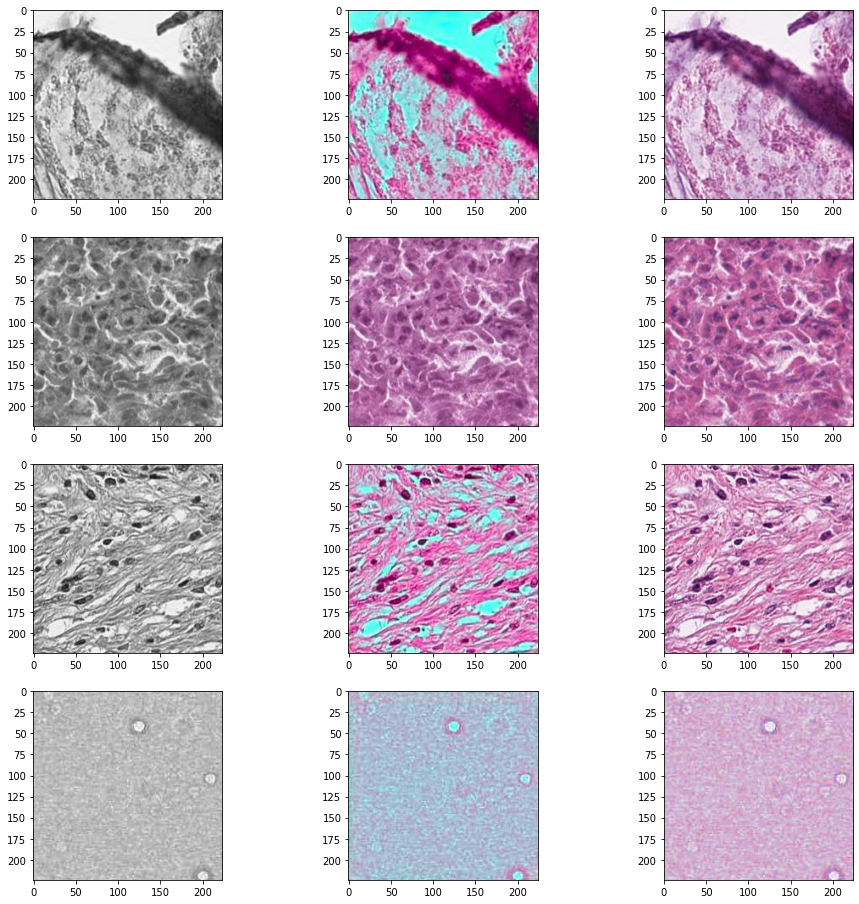

In [ ]:
# Select random 4 results to display.
# Order: Input, Predicted, Ground Truth
# Assumes all three results folder have the 4 files

filelist = shuffle(os.listdir('results/predicted/'))
filelist = filelist[:4]

fig, ax = plt.subplots(4, 3, figsize=(16,16))
row = 0
for filename in filelist:
    folder = 'results/bnw/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.0
    ax[row,0].imshow(image_in)
    
    folder = 'results/predicted/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.0
    ax[row,1].imshow(image_in)
    
    folder = 'results/actual/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.0
    ax[row,2].imshow(image_in)
    
    row += 1
    plt.savefig('sample_prediction_01.png')

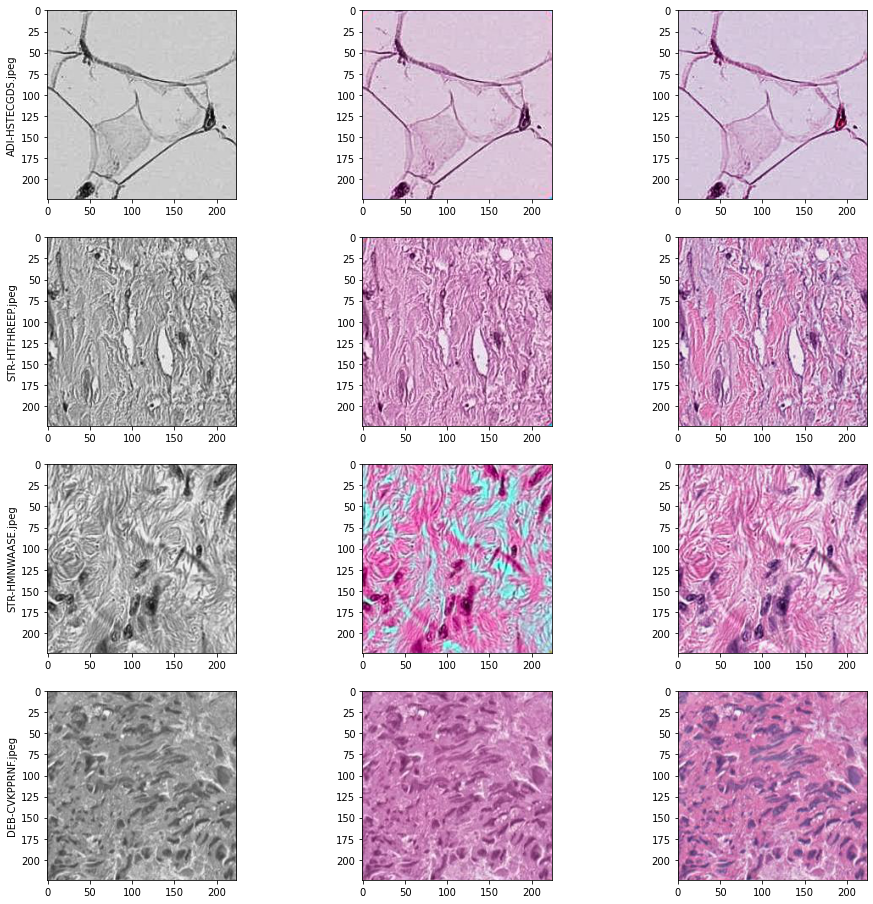

In [ ]:
filelist = shuffle(os.listdir("results/predicted"))
filelist = filelist[:4]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,16))
row=0

for filename in filelist:
    folder = "results/bnw/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,0].imshow(image_in)
    axes[row,0].set_ylabel(filename)
    
    folder = "results/predicted/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,1].imshow(image_in)
    
    folder = "results/actual/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,2].imshow(image_in)

    row+=1
    plt.savefig('sample_prediction_02.png')

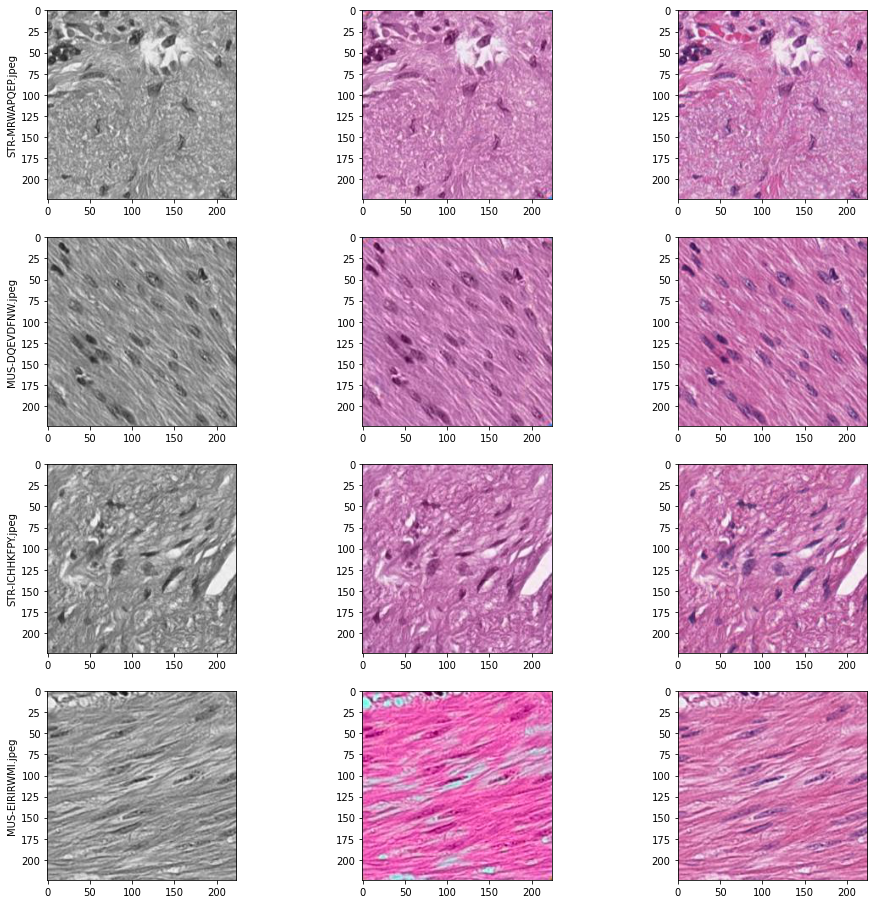

In [ ]:
filelist = shuffle(os.listdir("results/predicted"))
filelist = filelist[:4]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,16))
row=0

for filename in filelist:
    folder = "results/bnw/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,0].imshow(image_in)
    axes[row,0].set_ylabel(filename)
    
    folder = "results/predicted/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,1].imshow(image_in)
    
    folder = "results/actual/"
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255.
    axes[row,2].imshow(image_in)

    row+=1
    plt.savefig('sample_prediction_03.png')

## Evaluate the model

### VGG19 Model

In [ ]:
# Instantiate the vgg19 model without the top classifier. 
base_model = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top = False)

# Add a classifier to the convolution block classifier
x = base_model.output
flat = Flatten()(x)
hidden_1 = Dense(1024, activation='relu')(flat)
drop_1 = Dropout(0.2)(hidden_1)
hidden_2 = Dense(512, activation='relu')(drop_1)
drop_2 = Dropout(0.3)(hidden_2)
output = Dense(9, activation= 'softmax')(drop_2)

# Define the model
model_vgg19 = Model(base_model.inputs, output)

# Freeze all layers in the convolution block. We don't want to train these weights yet.
for layer in base_model.layers:
        layer.trainable=False
        
#model_vgg19_01.summary()

# Call Backs
#filepath = 
##es = EarlyStopping(monitor='loss', verbose=1, mode='min', patience=4)
#cp = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True,
#                     save_weights_only=False, mode='auto', period=1)

# Compile a model
model_vgg19.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

In [ ]:
model_vgg19.load_weights('/content/drive/MyDrive/neural_colorization_workspace/vgg19_model_finetuned.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Data Augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
true_images_dir = "/content/drive/MyDrive/neural_colorization_workspace/results/actual"

In [ ]:
# Image generator
true_test_generator = test_datagen.flow_from_directory(true_images_dir,
                                                       batch_size=1,
                                                       target_size=(224,224),
                                                       class_mode='categorical',
                                                       shuffle=False,
                                                       seed=42,
                                                       color_mode='rgb')

Found 15935 images belonging to 9 classes.


In [ ]:
vgg_eval_true = model_vgg19.evaluate(true_test_generator)

print('Loss:      {0:.4f}'.format(vgg_eval_true[0]))
print('Accuracy:  {0:.4f}'.format(vgg_eval_true[1]))


15935/15935 [==============================] - 5362s 336ms/step - loss: 0.0252 - accuracy: 0.9916
Loss:      0.0374
Accuracy:  0.9879


In [ ]:
# Predict Probabilities
vgg_predictions = model_vgg19.predict_generator(true_test_generator, verbose=1)
# Predict Labels
vgg_pred_labels = np.argmax(vgg_predictions, axis=1)



   16/15935 [..............................] - ETA: 1:53

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


15935/15935 [==============================] - 105s 7ms/step


In [ ]:
# Classification Report
print('|----------------------------------------------------------|')
print('|---------Raw_Data--Classification Report-(VGG19)----------|')
print('|----------------------------------------------------------|')
print(classification_report(true_test_generator.classes, vgg_pred_labels, 
                            target_names=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']))


|----------------------------------------------------------|
|---------Raw_Data--Classification Report-(VGG19)----------|
|----------------------------------------------------------|
              precision    recall  f1-score   support

         ADI       1.00      1.00      1.00      1669
        BACK       1.00      1.00      1.00      1648
         DEB       0.99      0.98      0.99      1899
         LYM       1.00      0.99      1.00      1891
         MUC       0.99      0.99      0.99      1400
         MUS       0.98      0.99      0.99      2143
        NORM       0.98      0.98      0.98      1369
         STR       0.97      0.98      0.97      1668
         TUM       0.98      0.99      0.99      2248

    accuracy                           0.99     15935
   macro avg       0.99      0.99      0.99     15935
weighted avg       0.99      0.99      0.99     15935



In [ ]:
# Confusion Matrices
true_vgg_conf_mat = pd.DataFrame(confusion_matrix(true_test_generator.classes, vgg_pred_labels), 
                        index=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'], 
                        columns=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])



(8.9, -0.1)

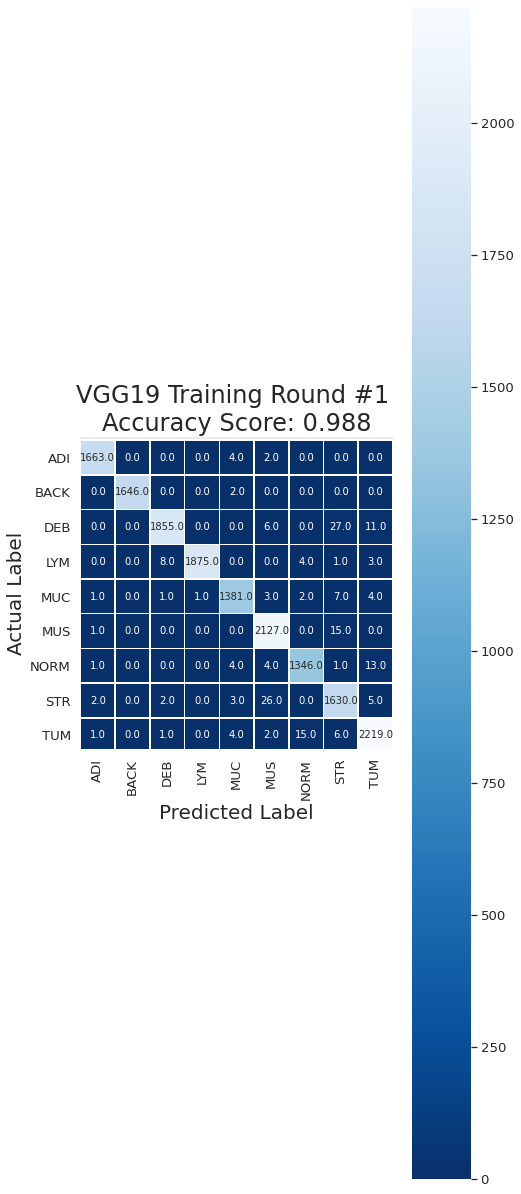

In [ ]:
# Plotting Confusion Matrices
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(7,35))

#ax1
sns.heatmap(true_vgg_conf_mat, ax=ax, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r', annot_kws={"size": 10})
ax.set_ylabel("Actual Label", fontsize=20)
ax.set_xlabel("Predicted Label", fontsize=20)
all_sample_title="VGG19 Training Round #1 \nAccuracy Score: {0:.3f}".format(vgg_eval_true[1])
ax.set_title(all_sample_title, size=24)
ax.set_ylim(len(true_vgg_conf_mat)-0.1, -0.1)

In [ ]:
predicted_images_dir = "/content/drive/MyDrive/neural_colorization_workspace/results/predicted"

In [ ]:
predicted_test_generator = test_datagen.flow_from_directory(predicted_images_dir,
                                                       batch_size=1,
                                                       target_size=(224,224),
                                                       class_mode='categorical',
                                                       shuffle=False,
                                                       seed=42,
                                                       color_mode='rgb')

Found 15851 images belonging to 9 classes.


In [ ]:
vgg_eval_pred = model_vgg19.evaluate(predicted_test_generator)

print('Loss:      {0:.4f}'.format(vgg_eval_pred[0]))
print('Accuracy:  {0:.4f}'.format(vgg_eval_pred[1]))


15851/15851 [==============================] - 5035s 318ms/step - loss: 2.1367 - accuracy: 0.6588
Loss:      2.1367
Accuracy:  0.6588


In [ ]:
# Predict Probabilities
colored_vgg_predictions = model_vgg19.predict_generator(predicted_test_generator, verbose=1)
# Predict Labels
colored_vgg_pred_labels = np.argmax(colored_vgg_predictions, axis=1)

# Classification Report
print('|----------------------------------------------------------|')
print('|---------Raw_Data--Classification Report-(VGG19)----------|')
print('|----------------------------------------------------------|')
print(classification_report(predicted_test_generator.classes, colored_vgg_pred_labels, 
                            target_names=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']))


   17/15851 [..............................] - ETA: 1:49

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


15851/15851 [==============================] - 105s 7ms/step
|----------------------------------------------------------|
|---------Raw_Data--Classification Report-(VGG19)----------|
|----------------------------------------------------------|
              precision    recall  f1-score   support

         ADI       0.86      0.84      0.85      1663
        BACK       0.99      0.95      0.97      1638
         DEB       0.68      0.79      0.73      1895
         LYM       0.77      0.66      0.71      1876
         MUC       0.36      0.66      0.46      1389
         MUS       0.48      0.17      0.25      2131
        NORM       0.79      0.76      0.77      1363
         STR       0.36      0.60      0.45      1653
         TUM       0.97      0.65      0.78      2243

    accuracy                           0.66     15851
   macro avg       0.70      0.67      0.66     15851
weighted avg       0.70      0.66      0.66     15851



In [ ]:
# Confusion Matrices
predicted_vgg_conf_mat = pd.DataFrame(confusion_matrix(predicted_test_generator.classes, colored_vgg_pred_labels), 
                        index=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'], 
                        columns=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])



(8.9, -0.1)

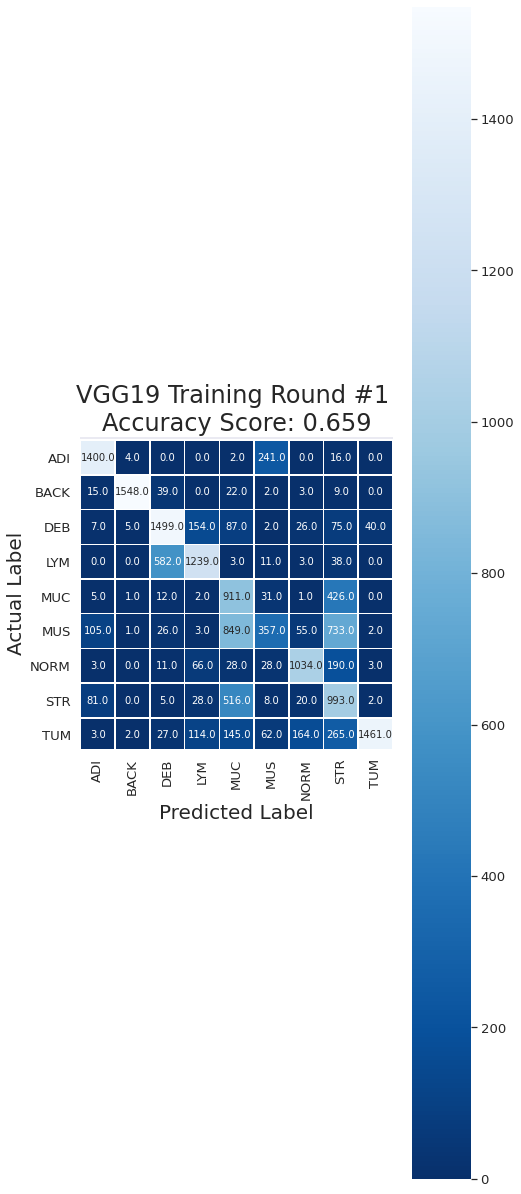

In [ ]:
# Plotting Confusion Matrices
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(7,35))

#ax1
sns.heatmap(predicted_vgg_conf_mat, ax=ax, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r', annot_kws={"size": 10})
ax.set_ylabel("Actual Label", fontsize=20)
ax.set_xlabel("Predicted Label", fontsize=20)
all_sample_title="nAccuracy Score: {0:.3f}".format(vgg_eval_pred[1])
ax.set_title(all_sample_title, size=24)
ax.set_ylim(len(predicted_vgg_conf_mat)-0.1, -0.1)